In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
import pickle as pkl
import pandas as pd
from astropy.io import fits
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from scipy.integrate import quad
from scipy.interpolate import interp1d
from astropy.table import Table
plt.rcParams['font.size']=45
plt.rcParams['axes.linewidth']= 3.
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams['figure.figsize']=(16,12)

In [43]:
def ghs(data1,data2):
    '''
    GHS - Geometric Histogram Separation
    ----------------------------------------------
    Input:
    data1,data2 - The data samples - list or numpy.ndarray
    Output:
    BCA, BCL, GHS - The metrics - tuple of float64
    ----------------------------------------------
    This function measures the Box Counting Area (BCA) and
    the Box Counting Linear (BCL) between data1 and data2.
    The GHS is measured as average of BCA square root and BCL.
    '''
    hist1, bins1 = np.histogram(data1)
    hist2, bins2 = np.histogram(data2)
    both = np.concatenate((bins1,bins2))
    # n is the number of bins (average between the number of both bins)
    n = int(len(both)/2)
    
    rnge = (np.min(both),np.max(both))
    hist1, bins1 = np.histogram(data1,bins=n,range=rnge,density=True)
    hist2, bins2 = np.histogram(data2,bins=n,range=rnge,density=True)

    # since both histograms have same bins, dy is the intersection:
    dx = (rnge[1]-rnge[0])/n
    dy = np.minimum(hist1,hist2)

    # ao is the relative area  
    ao = np.sum(dy*dx)

    a_height = np.max(hist1)
    b_height = np.max(hist2)
    c_height = np.max(dy)

    bcl = (a_height+b_height-2.0*c_height)/(a_height+b_height)
    bca = 1.0 - (ao) / (2.0 - ao)
    ghs = ( np.sqrt(bca) + bcl ) / 2.0
    return bca,bcl,ghs

In [6]:
SDS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike.csv')
TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike.csv')
Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike.csv')
blob = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/blobs_Rot_blobsLike.csv')
sk = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/sky_Rot_blobsLike.csv')

Text(0, 0.5, 'likelihood - blobs model')

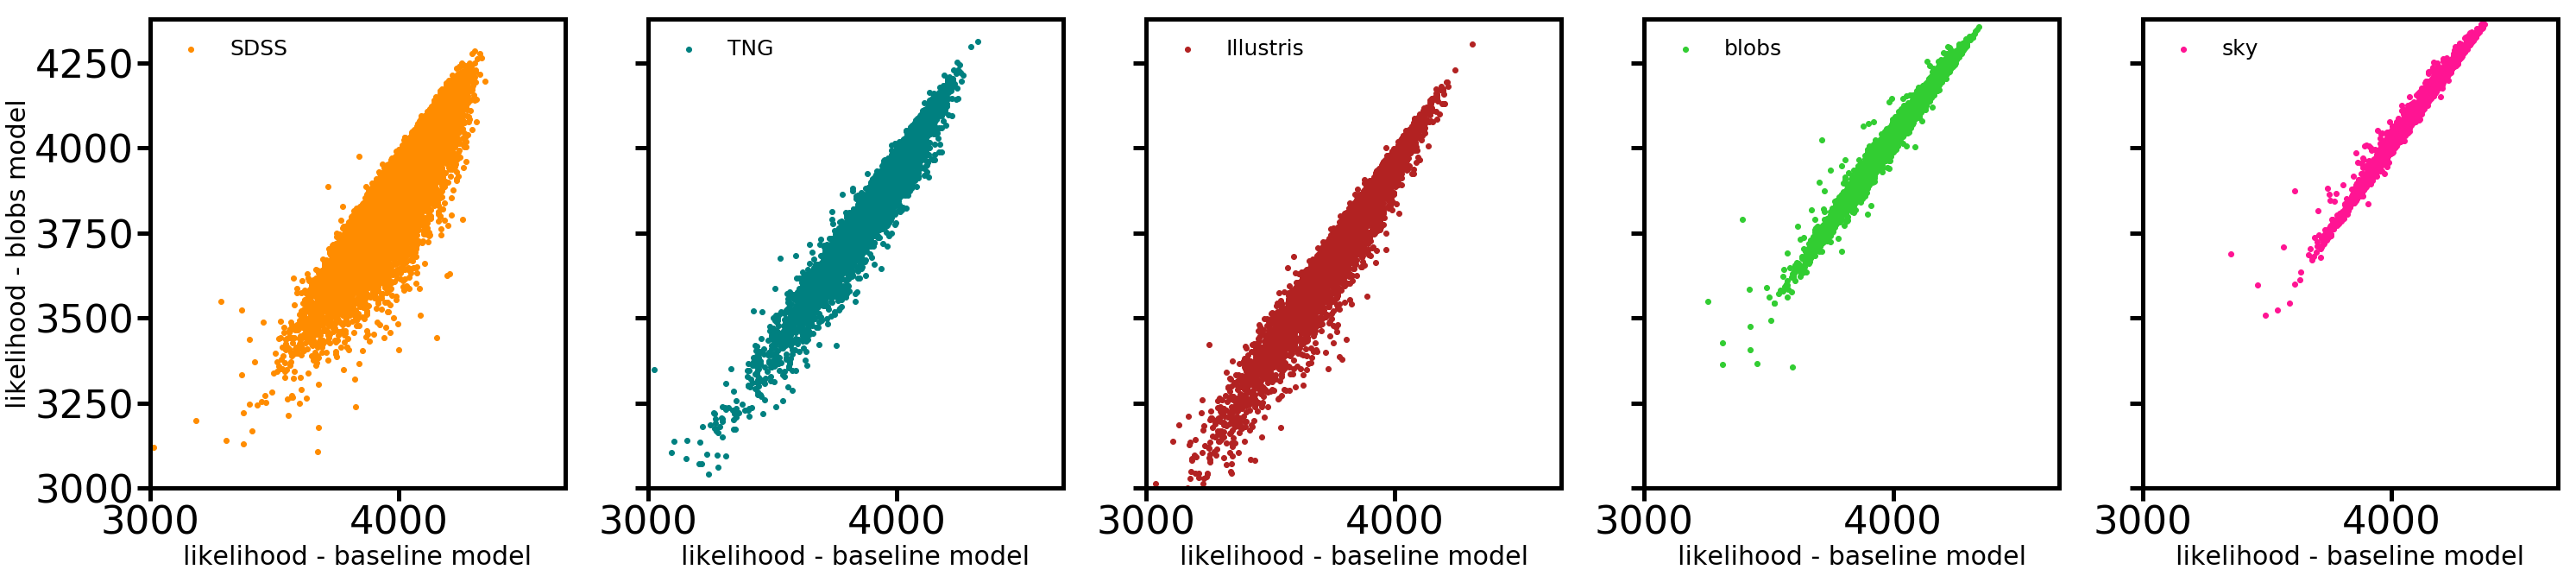

In [19]:
dsets = [SDS,TNG,Illustris, blob, sk]
labels = ['SDSS','TNG','Illustris','blobs','sky']
colors = ['darkorange','teal','firebrick','limegreen','deeppink']
fig, ax = plt.subplots(1,5,figsize=(50,10), sharey=True, sharex=True)
for i,this_ax in enumerate(ax.ravel()):
    this_ax.scatter(dsets[i]['likelihood'], dsets[i]['likelihood_shuffled'], label=labels[i], color=colors[i])
    this_ax.set_ylim(3000)
    this_ax.set_xlim(3000)
    this_ax.set_xlabel('likelihood - baseline model', fontsize=30)
    this_ax.legend(fontsize=25, frameon=False)
ax[0].set_ylabel('likelihood - blobs model', fontsize=30)


Text(0, 0.5, 'likelihood - blobs model')

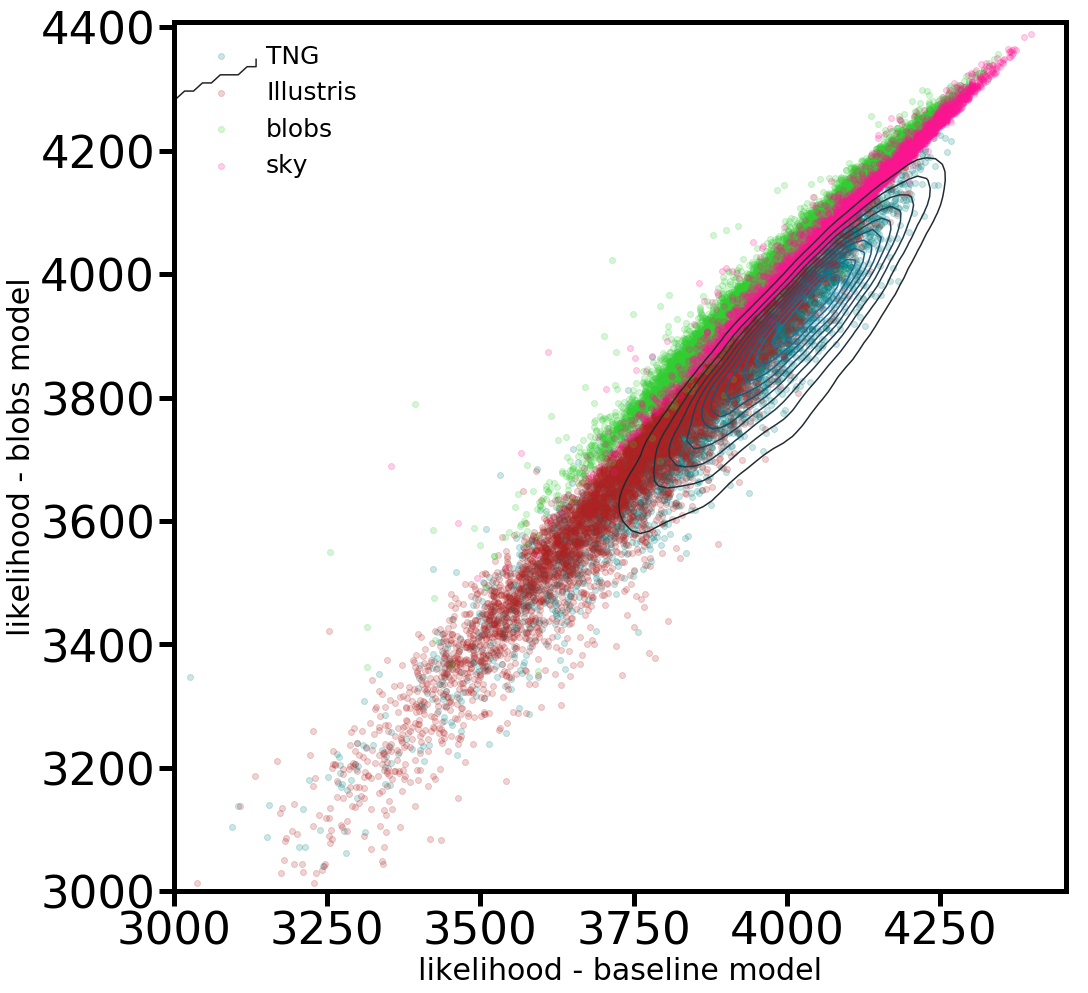

In [22]:
import seaborn as sns
dsets = [TNG,Illustris, blob, sk]
labels = ['TNG','Illustris','blobs','sky']
colors = ['teal','firebrick','limegreen','deeppink']
fig, ax = plt.subplots(1,1, figsize=(16,16))
SDS = SDS.query('likelihood>3000 & likelihood_shuffled>3000')
for i,d in enumerate(dsets):
    ax.scatter(dsets[i]['likelihood'], dsets[i]['likelihood_shuffled'], label=labels[i], color=colors[i], alpha=0.2)
    ax.set_ylim(3000)
    ax.set_xlim(3000)

sns.kdeplot(SDS['likelihood'].values, SDS['likelihood_shuffled'].values)
ax.set_xlabel('likelihood - baseline model', fontsize=30)
plt.legend(fontsize=25, frameon=False)
ax.set_ylabel('likelihood - blobs model', fontsize=30)

In [3]:
logchi= np.log10(SDS.query('chi2nu<2')['chi2nu'])

Text(0.5, 0, 'LLR')

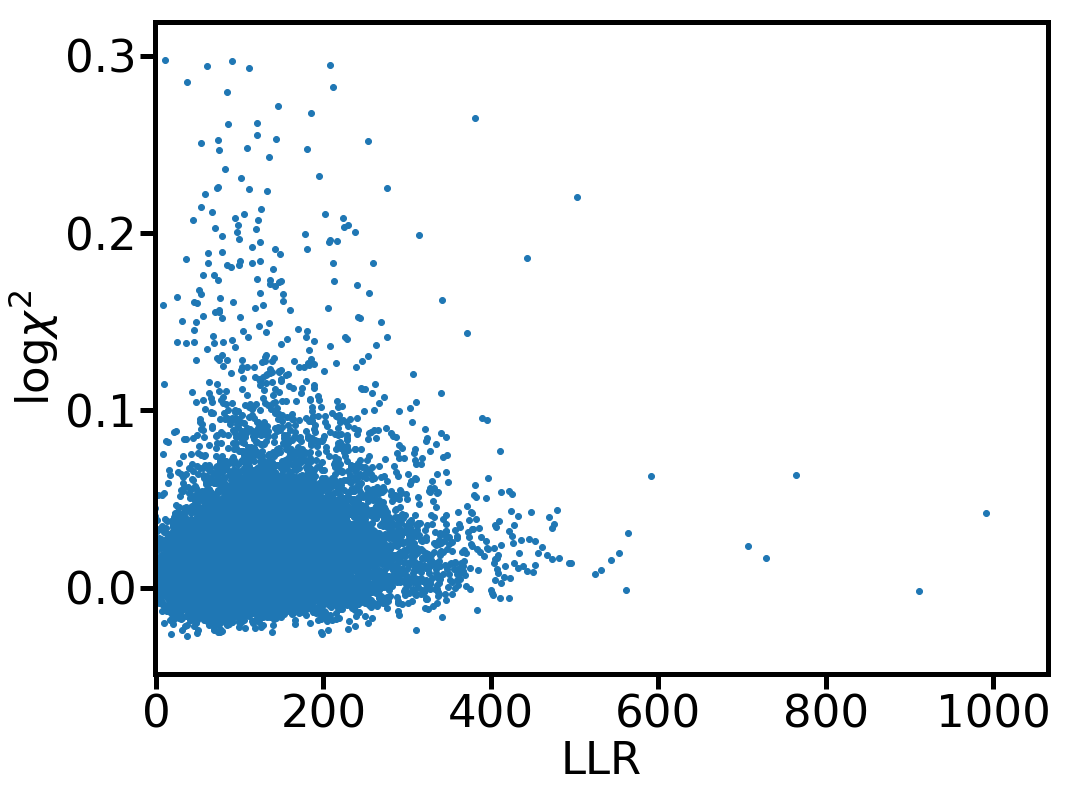

In [7]:

plt.scatter(SDS.query('chi2nu<2')['LLR'], logchi)
plt.xlim(-1)

plt.ylabel('log$\chi^2$')
plt.xlabel('LLR')

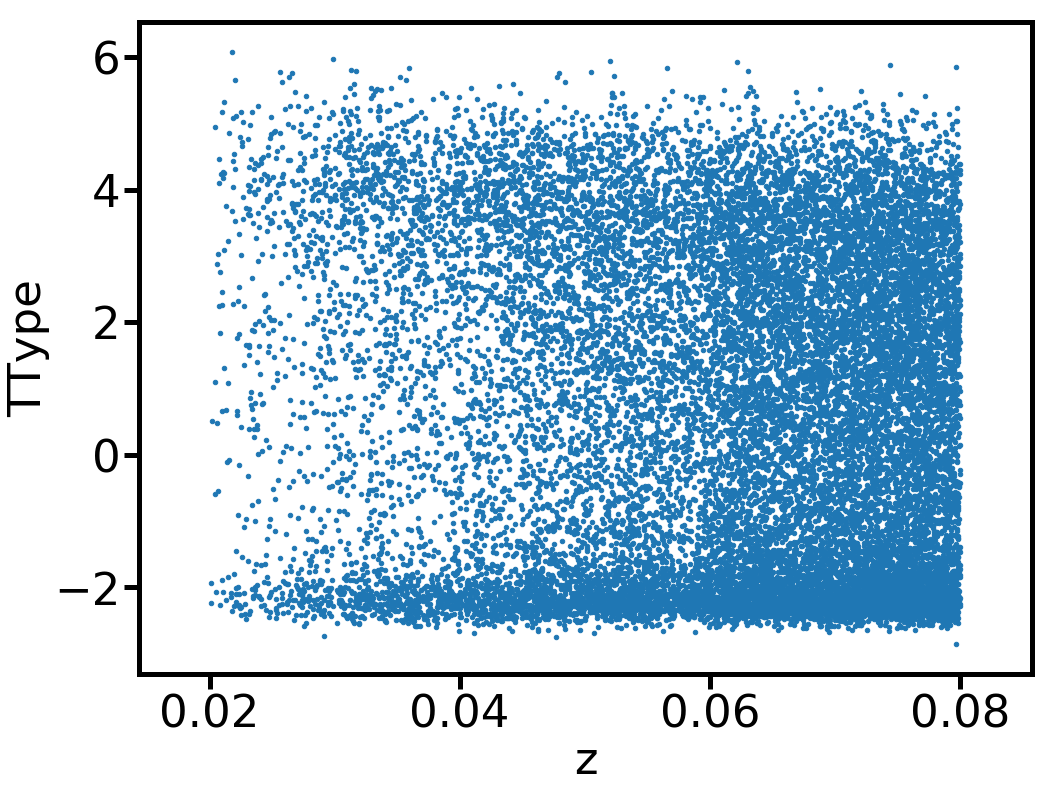

In [50]:
SDSS.plot.scatter('z','TType')

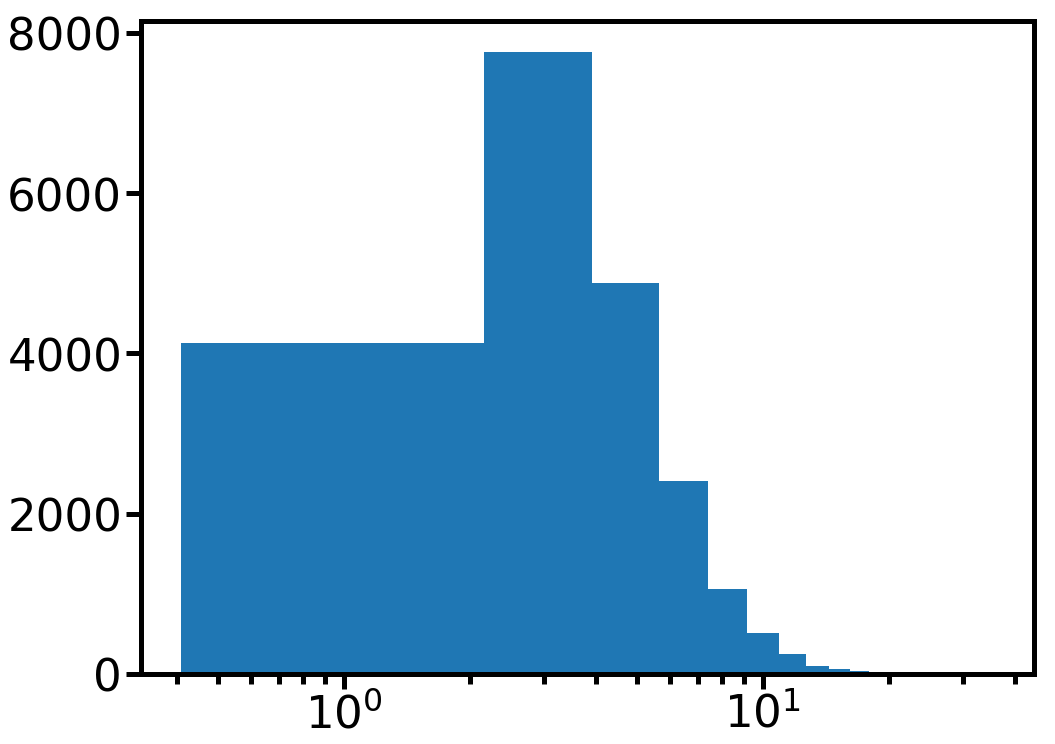

In [6]:
plt.hist(SDSS.r_bulge, bins=20)
plt.xscale('log')

In [8]:
up_TNG = np.percentile(TNG.sersic_rhalf, 99.7)
TNG = TNG[TNG.sersic_rhalf<up_TNG]
TNG = TNG.query('flag_sersic==0')

#median = TNG.sersic_rhalf.apply(np.log10).median()
TNG_high = TNG[TNG.P_Late_comp>0.5]
TNG_low = TNG[TNG.P_Late_comp<0.5]

median = SDS.r_bulge.apply(np.log10).median()                
SDS_high = SDS[SDS.TType>0]
SDS_low = SDS[SDS.TType<0]
bins = np.arange(-50,1000,5)
fig, ax = plt.subplots(1,1)
TNG_high['LLR'].hist(bins=bins, histtype='step', label='TNG high', ax=ax, density=True, ls=':', color='firebrick', lw=5)
TNG_low['LLR'].hist(bins=bins, histtype='step', label='TNG low', ax=ax, density=True, ls=':', color='pink', lw=5)
SDS_high['LLR'].hist(bins=bins, histtype='step', label='SDSS high', ax=ax, density=True,ls='-', color='darkorange', lw=5)
SDS_low['LLR'].hist(bins=bins, histtype='step', label='SDSS low', ax=ax, density=True, ls='-', color='gold', lw=5)

plt.legend()

In [267]:
_, TNG_score = ks_2samp(TNG_high['LLR'], TNG_low['LLR'])
_, SDSS_score = ks_2samp(SDS_high['LLR'], SDS_low['LLR'])

In [ ]:
sizeTNG = TNG.sersic_rhalf.apply(lambda x: x/0.7/(1+0.485)).values

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


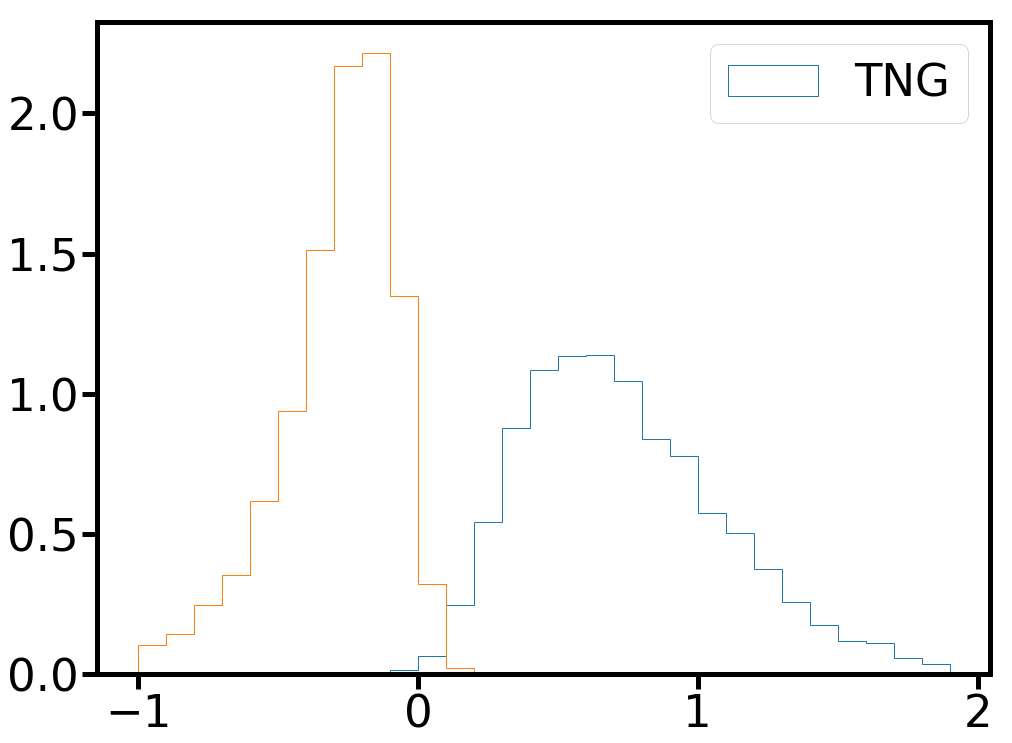

In [86]:
bins = np.arange(-1,2,0.1)
plt.hist(np.log10(sizeTNG), bins=bins, histtype='step', density=True, label='TNG')
plt.hist(np.log10(SDS.r_bulge.apply(np.log10)), bins=bins,histtype='step', density=True)
plt.legend()

# with KDE

In [81]:

#up_TNG = np.percentile(TNG.sersic_rhalf, 99.7)
#TNG_ = TNG[TNG.sersic_rhalf<up_TNG]
TNG_ = TNG.query('flag_sersic==0')
Illustris_ = Illustris.query('flag_sersic==0')

median = TNG_.sersic_n.median()
TNG_high = TNG_[TNG_.sersic_n>median]
TNG_low = TNG_[TNG_.sersic_n<median]
print(median)
median = Illustris_.sersic_n.median()
Illustris_high = Illustris_[Illustris_.sersic_n>median]
Illustris_low = Illustris_[Illustris_.sersic_n<median]

median = SDS.n_bulge.median()                #
print(median)
SDS_high = SDS[SDS.n_bulge>median]
SDS_low = SDS[SDS.n_bulge<median]

median = blob.n_bulge.median()                #
blob_high = blob[blob.n_bulge>median]
blob_low = blob[blob.n_bulge<median]

1.7467999458312988
2.3523


In [46]:
TNG_LLR =ghs(TNG_high['LLR'], TNG_low['LLR'])[2]
TNG_L = ghs(TNG_high['likelihood'], TNG_low['likelihood'])[2] 
SDSS_LLR = ghs(SDS_high['LLR'], SDS_low['LLR'])[2]
SDSS_L = ghs(SDS_high['likelihood'], SDS_low['likelihood'])[2] 
Illustris_LLR = ghs(Illustris_high['LLR'], Illustris_low['LLR'])[2]
Illustris_L = ghs(Illustris_high['likelihood'], Illustris_low['likelihood'])[2] 
print('GHS for TNG\n for LLR: GHS = {} \n for likelihood: GHS = {}'.format(TNG_LLR,TNG_L))
print('GHS for SDSS\n for LLR: GHS = {} \n for likelihood: GHS = {}'.format(SDSS_LLR,SDSS_L))
print('GHS for Illustris\n for LLR: GHS = {} \n for likelihood: GHS = {}'.format(Illustris_LLR,Illustris_L))

GHS for TNG
 for LLR: GHS = 0.3715337711279638 
 for likelihood: GHS = 0.5076227189511742
GHS for SDSS
 for LLR: GHS = 0.1470989608386873 
 for likelihood: GHS = 0.4763518048337433
GHS for Illustris
 for LLR: GHS = 0.14038997010411744 
 for likelihood: GHS = 0.3540021946809291


In [47]:
a = np.random.normal(size=10000)
ghs(a,a)

(1.1102230246251565e-16, 0.0, 5.268356063861754e-09)

In [77]:
LLR_TNGh = gaussian_kde(TNG_high['LLR'])
LLR_TNGl = gaussian_kde(TNG_low['LLR'])
LLR_Illustrish = gaussian_kde(Illustris_high['LLR'])
LLR_Illustrisl = gaussian_kde(Illustris_low['LLR'])
#kernel_TNG = gaussian_kde(TNG['likelihood'])
LLR_SDSh = gaussian_kde(SDS_high['LLR'])
LLR_SDSl = gaussian_kde(SDS_low['LLR'])
LLR_blobh = gaussian_kde(-blob_high['LLR'])
LLR_blobl = gaussian_kde(-blob_low['LLR'])


In [78]:
L_TNGh = gaussian_kde(TNG_high['likelihood'])
L_TNGl = gaussian_kde(TNG_low['likelihood'])
L_Illustrish = gaussian_kde(Illustris_high['likelihood'])
L_Illustrisl = gaussian_kde(Illustris_low['likelihood'])
#kernel_TNG = gaussian_kde(TNG['likelihood'])
L_SDSh = gaussian_kde(SDS_high['likelihood'])
L_SDSl = gaussian_kde(SDS_low['likelihood'])
L_blobh = gaussian_kde(blob_high['likelihood'])
L_blobl = gaussian_kde(blob_low['likelihood'])



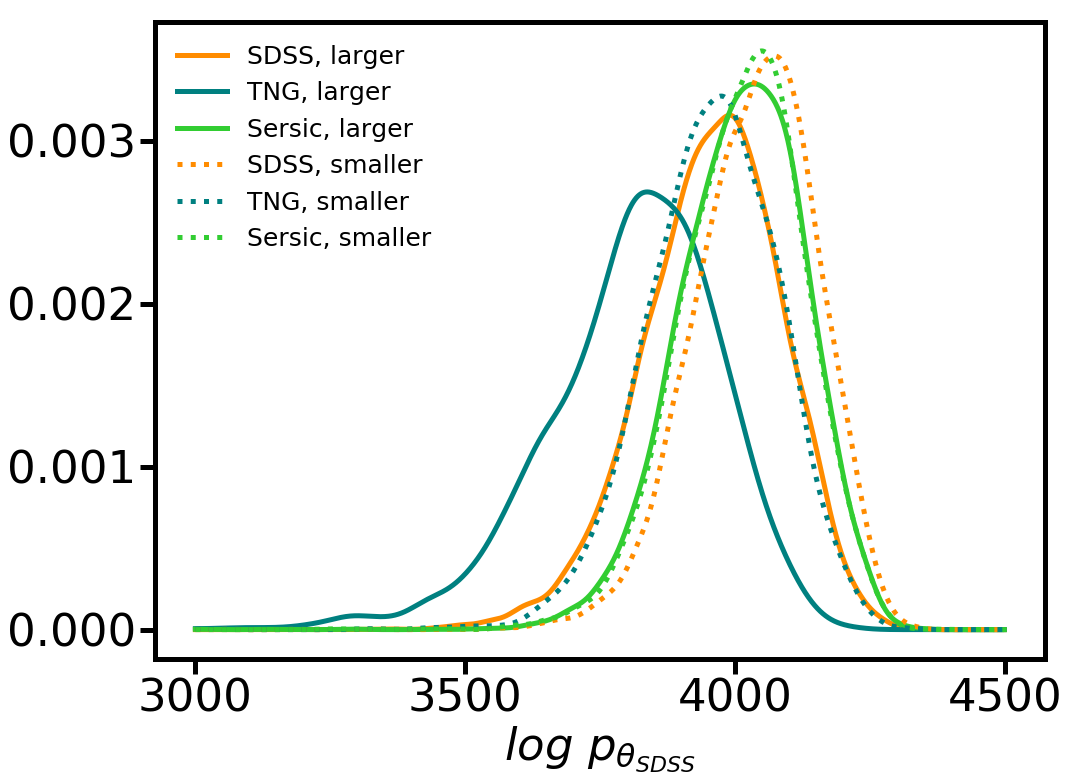

In [66]:
x = np.arange(3000,4500)
#plt.plot(x, kernel_TNG(x), label='TNG, all', lw=5, ls=':', color='black')
plt.plot(x, L_SDSh(x), label= 'SDSS, larger', lw=5, color='darkorange')
plt.plot(x, L_TNGh(x), label='TNG, larger', lw=5, color='teal')
plt.plot(x, L_blobh(x), label='Sersic, larger', lw=5, color='limegreen')

#plt.plot(x, L_Illustrish(x), label='Illustris, $r>r_{median}$', lw=5, color='firebrick')

plt.plot(x, L_SDSl(x), label= 'SDSS, smaller', lw=5, ls=':', color='darkorange')
plt.plot(x, L_TNGl(x), label='TNG, smaller', lw=5, ls=':', color='teal')
plt.plot(x, L_blobl(x), label='Sersic, smaller', lw=5, color='limegreen', ls=':')

#plt.plot(x, L_Illustrisl(x), label='Illustris, $r<r_{median}$', lw=5, ls=':',color='firebrick')

plt.legend(fontsize=25, frameon=False)
plt.xlabel(r'$log \ p_{\theta_{SDSS}}$')
#plt.xlabel('LLR')
plt.tight_layout()
plt.savefig('./results/likelihood_plots/likelihood_rbulge_noIllustris_yesblobs.png') 

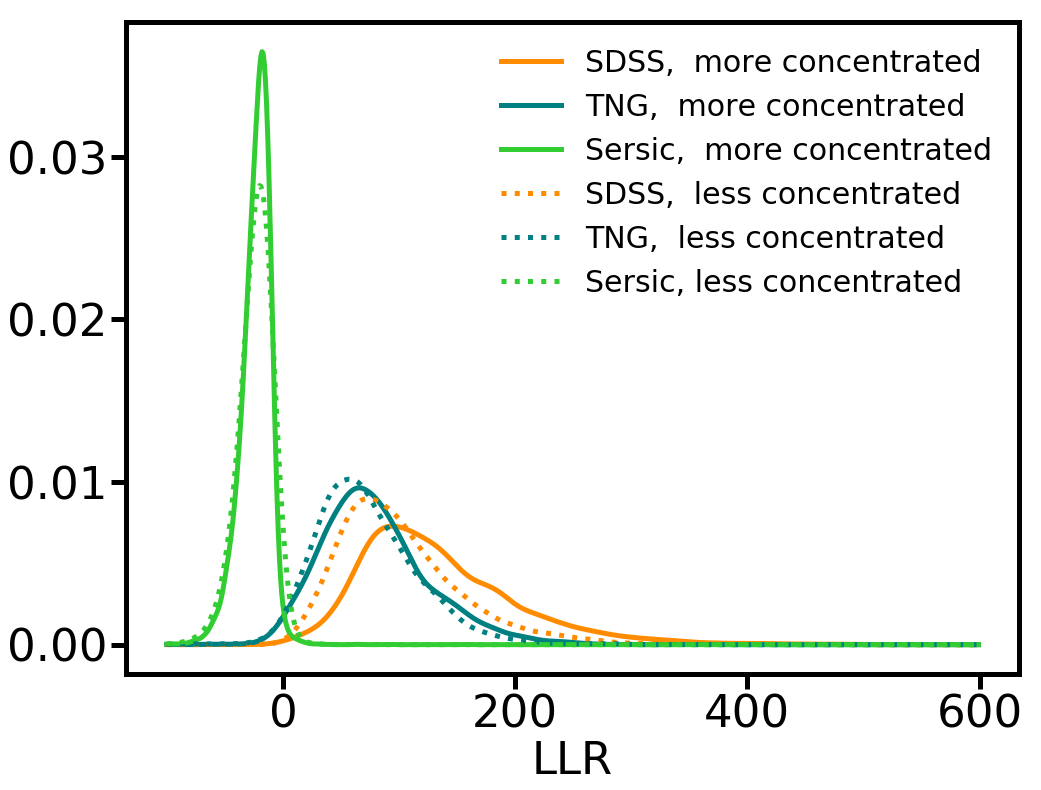

In [79]:
x = np.arange(-100,600)
#plt.plot(x, kernel_TNG(x), label='TNG, all', lw=5, ls=':', color='black')
plt.plot(x, LLR_SDSh(x), label= 'SDSS,  more concentrated', lw=5, color='darkorange')
plt.plot(x, LLR_TNGh(x), label='TNG,  more concentrated', lw=5, color='teal')
plt.plot(x, LLR_blobh(x), label='Sersic,  more concentrated', lw=5, color='limegreen',)

#plt.plot(x, LLR_Illustrish(x), label='Illustris, $r>r_{median}$', lw=5, color='firebrick')

plt.plot(x, LLR_SDSl(x), label= 'SDSS,  less concentrated' , lw=5, ls=':', color='darkorange')
plt.plot(x, LLR_TNGl(x), label='TNG,  less concentrated' , lw=5, ls=':', color='teal')
plt.plot(x, LLR_blobl(x), label='Sersic, less concentrated' , lw=5, color='limegreen',ls=':')

#plt.plot(x, LLR_Illustrisl(x), label='Illustris, $r<r_{median}$', lw=5, ls=':', color='firebrick')

plt.legend(fontsize=30, frameon=False)
#plt.xlabel(r'$log \ p_{\theta_{sersic}}$')
plt.xlabel('LLR')
plt.savefig('./results/likelihood_plots/LLR_nbulge_noillustris_yesblobs.png') 

In [83]:
percentiles= np.percentile(SDS.n_bulge,[0.1,25,50,75,99.9])

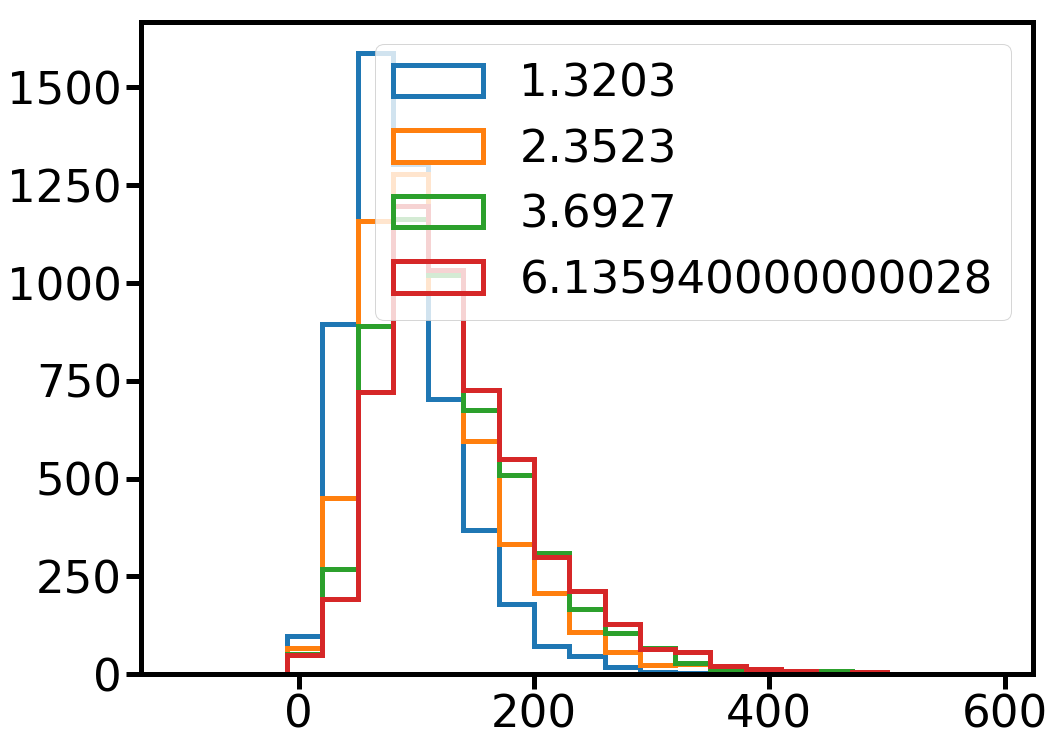

In [90]:
fig, ax = plt.subplots(1,1)
bins = np.arange(-100,600,30)
for p in range(len(percentiles)-1):
    SDS_ = SDS[(SDS.n_bulge<percentiles[p+1]) & (SDS.n_bulge>percentiles[p])]['LLR']
    ax.hist(SDS_, bins=bins, label=percentiles[p+1], histtype='step', lw=5)
plt.legend()

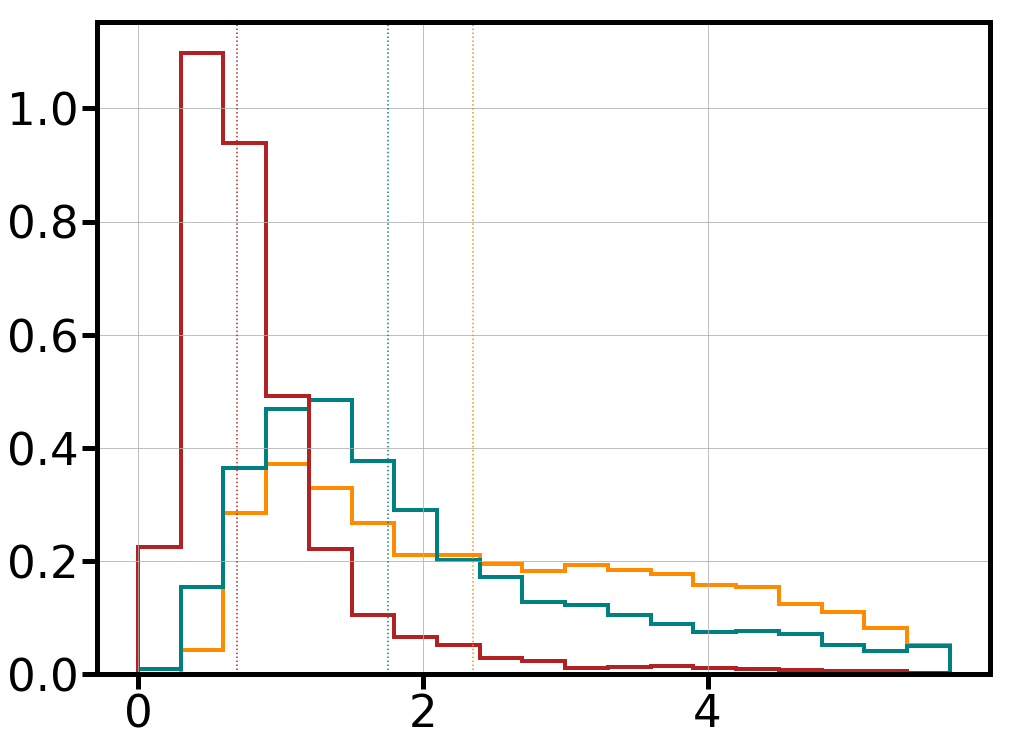

In [75]:
fig,ax = plt.subplots(1,1)
SDS.n_bulge.hist(bins=np.arange(0,6,0.3), ax=ax, histtype='step', density=True, label='SDSS', lw=4, color='darkorange')
TNG.sersic_n.hist(bins=np.arange(0,6,0.3), ax=ax, histtype='step', density=True, label='TNG', lw=4, color='teal')
Illustris.sersic_n.hist(bins=np.arange(0,6,0.3), ax=ax, histtype='step', density=True, label='Illustris', lw=4, color='firebrick')

ax.axvline(TNG.sersic_n.median(), color='teal', ls=':')
ax.axvline(SDS.n_bulge.median(), color='darkorange', ls=':')
ax.axvline(Illustris.sersic_n.median(), color='firebrick', ls=':')

# Where are the bright disks?

In [76]:
SDS_ = SDS.query('TType>0')
SDS_ETGs = SDS.query('TType<0')

median = SDS['m_bulge'].median()  #median of all the population
LLR_lowm = gaussian_kde(SDS_[SDS_['m_bulge']<median]['LLR'])
LLR_highm = gaussian_kde(SDS_[SDS_['m_bulge']>median]['LLR'])
L_lowm = gaussian_kde(SDS_[SDS_['m_bulge']<median]['likelihood'])
L_highm = gaussian_kde(SDS_[SDS_['m_bulge']>median]['likelihood'])

LLR_lowmETGs = gaussian_kde(SDS_ETGs[SDS_ETGs['m_bulge']<median]['LLR'])
LLR_highmETGs = gaussian_kde(SDS_ETGs[SDS_ETGs['m_bulge']>median]['LLR'])
L_lowmETGs = gaussian_kde(SDS_ETGs[SDS_ETGs['m_bulge']<median]['likelihood'])
L_highmETGs = gaussian_kde(SDS_ETGs[SDS_ETGs['m_bulge']>median]['likelihood'])

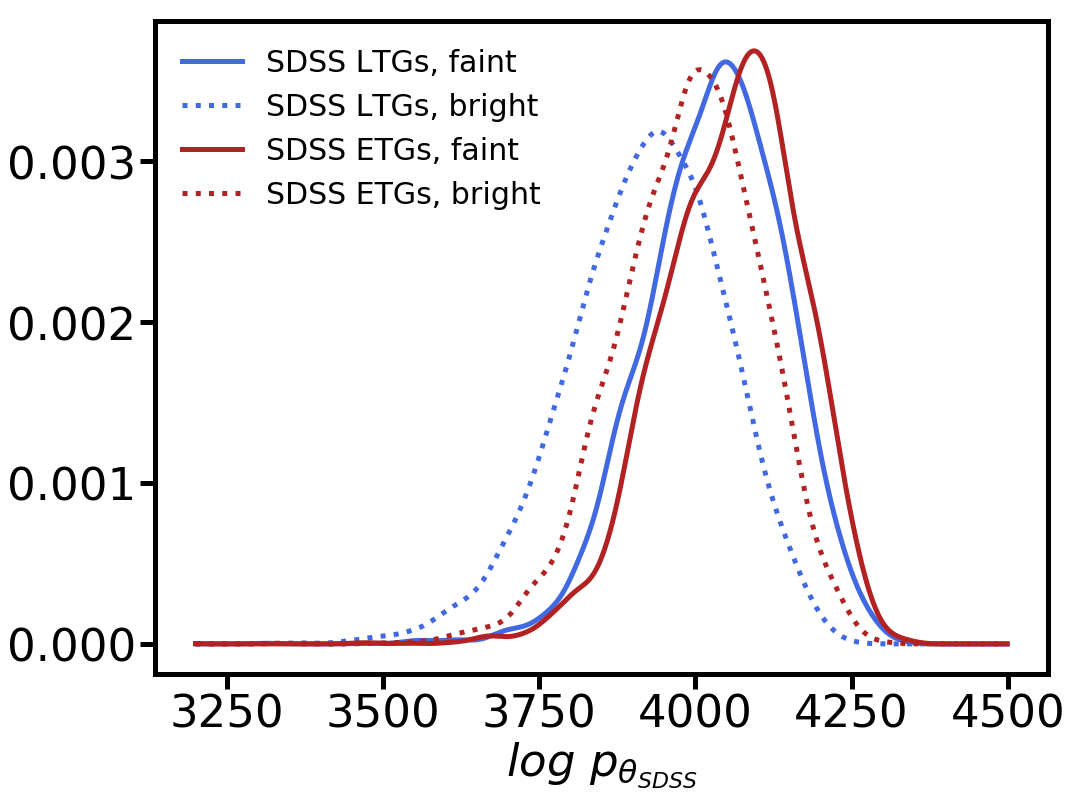

In [48]:
x=np.arange(3200,4500)
plt.plot(x, L_highm(x), label= 'SDSS LTGs, faint', lw=5, color='royalblue')
plt.plot(x, L_lowm(x), label= 'SDSS LTGs, bright', lw=5, ls=':', color='royalblue')
plt.plot(x, L_highmETGs(x), label= 'SDSS ETGs, faint', lw=5, color='firebrick')
plt.plot(x, L_lowmETGs(x), label= 'SDSS ETGs, bright', lw=5, ls=':', color='firebrick')
plt.legend(fontsize=30, frameon=False)
plt.xlabel(r'$log \ p_{\theta_{SDSS}}$')
plt.savefig('./results/likelihood_plots/likelihood_SDSS_brightness_TType.pdf') 

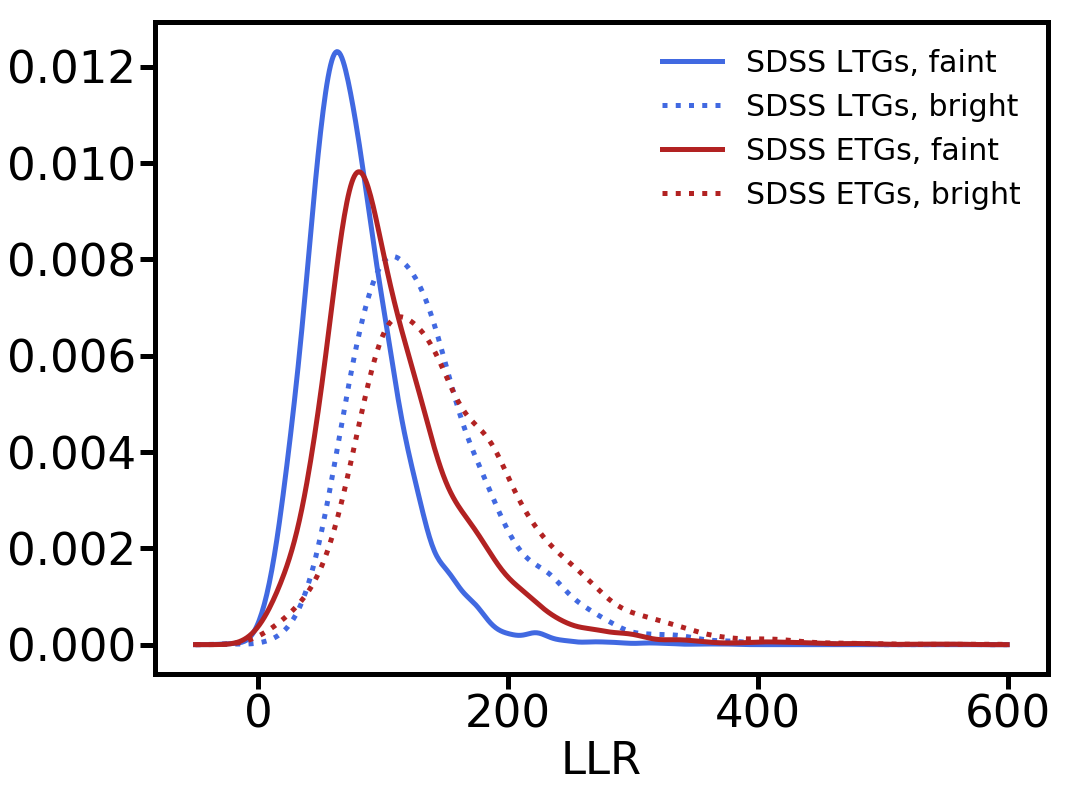

In [77]:
x=np.arange(-50,600)
plt.plot(x, LLR_highm(x), label= 'SDSS LTGs, faint', lw=5, color='royalblue')
plt.plot(x, LLR_lowm(x), label= 'SDSS LTGs, bright', lw=5, ls=':', color='royalblue')
plt.plot(x, LLR_highmETGs(x), label= 'SDSS ETGs, faint', lw=5, color='firebrick')
plt.plot(x, LLR_lowmETGs(x), label= 'SDSS ETGs, bright', lw=5, ls=':', color='firebrick')
plt.legend(fontsize=30, frameon=False)
plt.xlabel('LLR')
plt.savefig('./results/likelihood_plots/LLR_SDSS_brightness_TType.pdf') 

In [49]:
import seaborn as sns

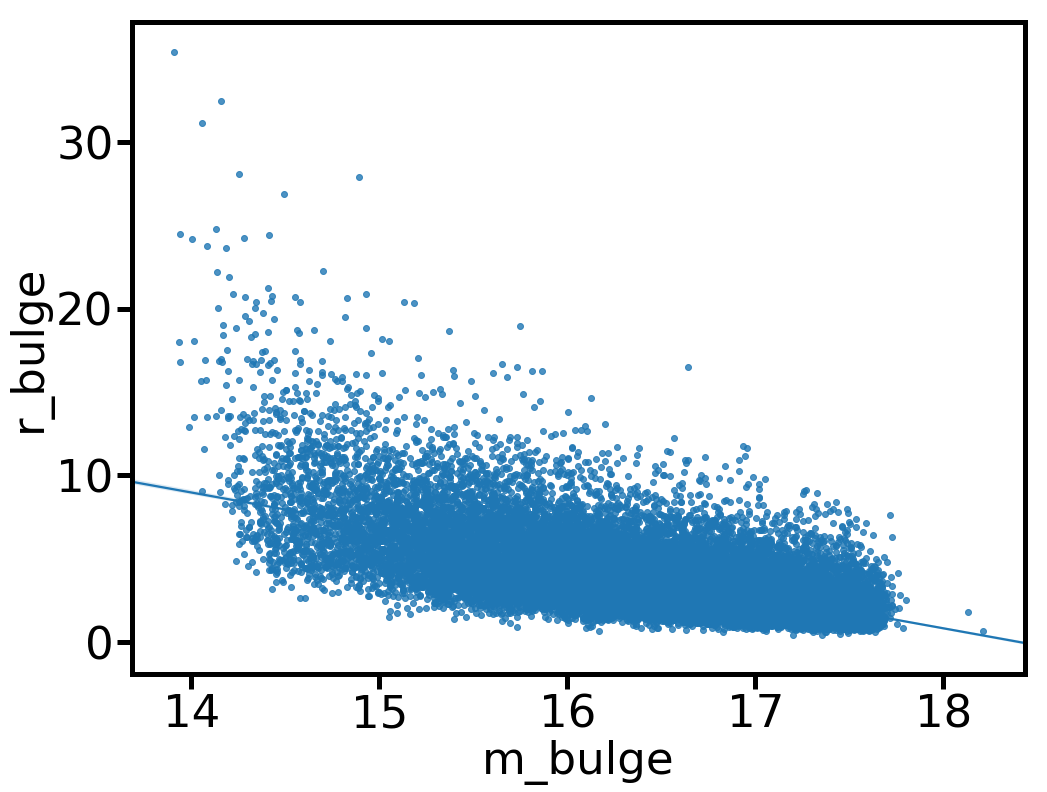

In [51]:
sns.regplot('m_bulge','r_bulge', data=SDS)

# check shared area

In [83]:
diff = []
vec = [(LLR_TNGh, LLR_TNGl), (LLR_SDSh, LLR_SDSl)] #, (LLR_TNGh, LLR_TNGl), (LLR_SDSh, LLR_SDSl)]
for item in vec:
    x = np.arange(-50,1000)
    y = abs(item[0](x)-item[1](x))
    interp = interp1d(x,y)
    diff.append(quad(interp, -40,900))
diff = np.array(diff)

/scratch/lzanisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


In [84]:
diff

array([[4.14974172e-01, 4.78825699e-04],
       [1.52014847e-01, 1.22379806e-04]])

In [50]:
Areas

array([[9.98303361e-01, 6.63131521e-09],
       [9.97253944e-01, 2.42165454e-10],
       [9.99699149e-01, 1.24739897e-08],
       [9.99342083e-01, 4.53499151e-09]])

In [263]:
x = np.arange(-10,500)
TNG_KL = entropy(kernel_TNGh(x), kernel_TNGl(x))
SDSS_KL = entropy(kernel_SDSh(x), kernel_SDSl(x))

In [264]:
TNG_KL, SDSS_KL

(0.1683132241245785, 0.01687493941393185)

In [2]:
SDSS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike.csv')
blobs = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/blobs_Rot_blobsLike.csv')

In [29]:
SDSS.b

0.06452909999999999

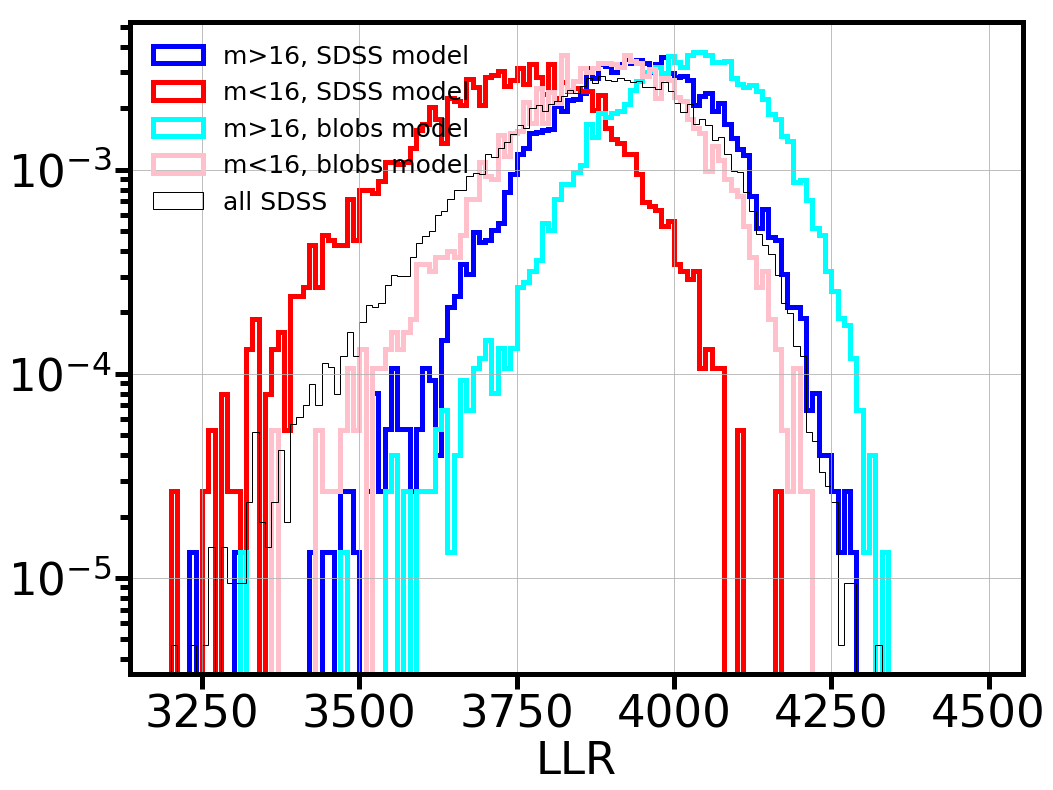

In [5]:


LTGs_SDSS = SDSS.query('m_bulge>16 & TType>0')
ETGs_SDSS = SDSS.query('m_bulge<16  & TType>0')#'& P_S0<0.5')
#S0s_SDSS = SDSS.query('Trype<0 &3S0>0.5' )

LTGs_blobs = SDSS.query('n_bulge>2.5')
ETGs_blobs = SDSS.query('n_bulge<2.5')# & P_S0<0.5')
#S0s_blobs = blobs.query('TType<0 & P_S0>0.5' )

#LTGs
fig,ax = plt.subplots(1,1)
bins = np.arange(3200,4500,10)
LTGs_SDSS['likelihood_shuffled'].hist(bins=bins,ax=ax, histtype='step', label='m>16, SDSS model', color='blue', lw=5,normed=True) #, density=True)
ETGs_SDSS['likelihood_shuffled'].hist(bins=bins,ax=ax, histtype='step', label='m<16, SDSS model', color='red', lw=5,normed=True) #, density=True, ls='--')
LTGs_SDSS['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='m>16, blobs model', color='cyan', lw=5,normed=True) #, density=True)
ETGs_SDSS['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='m<16, blobs model', color='pink', lw=5,normed=True) #, density=True, ls='--')
#S0s_SDSS['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='S0s', color='darkorange', lw=5, density=True, ls=':')
SDSS['likelihood_shuffled'].hist(bins=bins,ax=ax, histtype='step', label='all SDSS', color='black', lw=1, normed=True) #, density=True)

#LTGs_blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='n<2.5 blobs', color='cyan', lw=5) #, density=True)
#ETGs_blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='n>2.5 blobs', color='magenta', lw=5) #, density=True, ls='--')
#S0s_blobs['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='S0s', color='limegreen', lw=5, density=True, ls=':')
#blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='all blobs', color='gray', lw=1)
plt.xlabel('LLR')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=25, frameon=False)

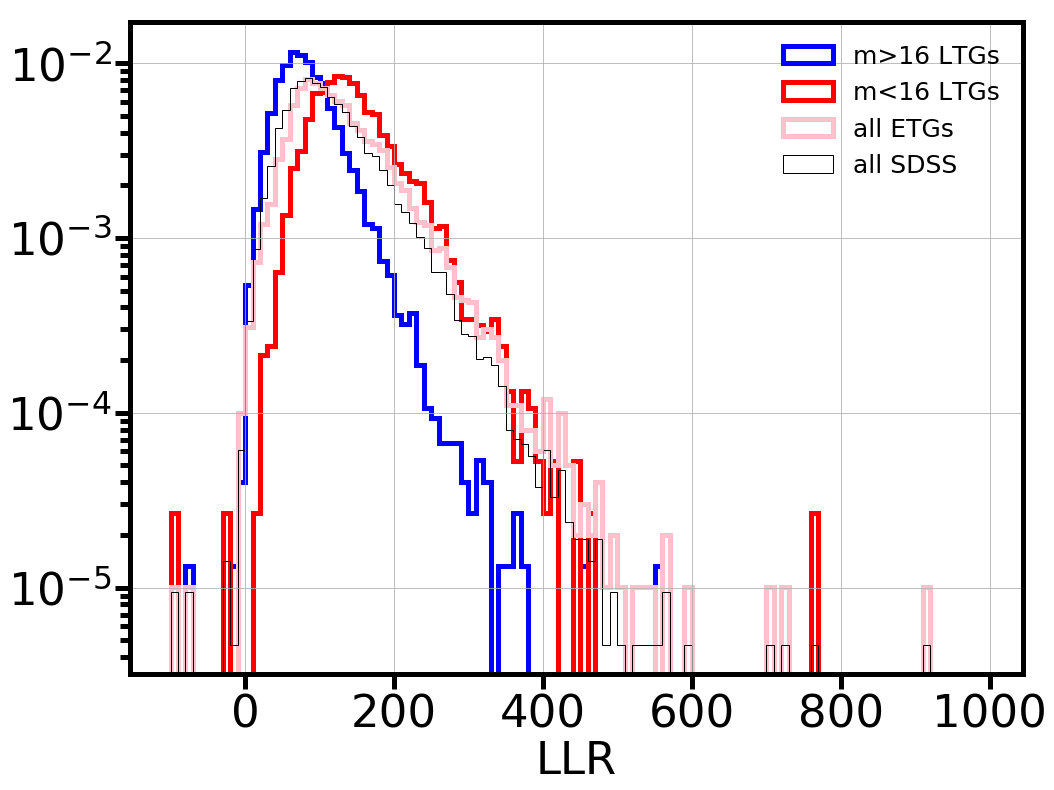

In [7]:
fig,ax = plt.subplots(1,1)
bins = np.arange(-100,1000,10)
plipSDSS = SDSS.query(' TType<0')
LTGs_SDSS['LLR'].hist(bins=bins,ax=ax, histtype='step', label='m>16 LTGs', color='blue', lw=5,normed=True) #, density=True)
ETGs_SDSS['LLR'].hist(bins=bins,ax=ax, histtype='step', label='m<16 LTGs', color='red', lw=5,normed=True) #, density=True, ls='--')
#LTGs_SDSS['LLR'].hist(bins=bins,ax=ax, histtype='step', label='n>2.5 SDSS', color='cyan', lw=5,normed=True) #, density=True)
plipSDSS['LLR'].hist(bins=bins,ax=ax, histtype='step', label='all ETGs', color='pink', lw=5,normed=True) #, density=True, ls='--')
#S0s_SDSS['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='S0s', color='darkorange', lw=5, density=True, ls=':')
SDSS['LLR'].hist(bins=bins,ax=ax, histtype='step', label='all SDSS', color='black', lw=1, normed=True) #, density=True)

#LTGs_blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='n<2.5 blobs', color='cyan', lw=5) #, density=True)
#ETGs_blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='n>2.5 blobs', color='magenta', lw=5) #, density=True, ls='--')
#S0s_blobs['likelihood'].hist(bins=bins,ax=ax, histtype='step', label='S0s', color='limegreen', lw=5, density=True, ls=':')
#blobs['LLR'].hist(bins=bins,ax=ax, histtype='step', label='all blobs', color='gray', lw=1)
plt.legend(fontsize=25, frameon=False)
plt.xlabel('LLR')
plt.yscale('log')

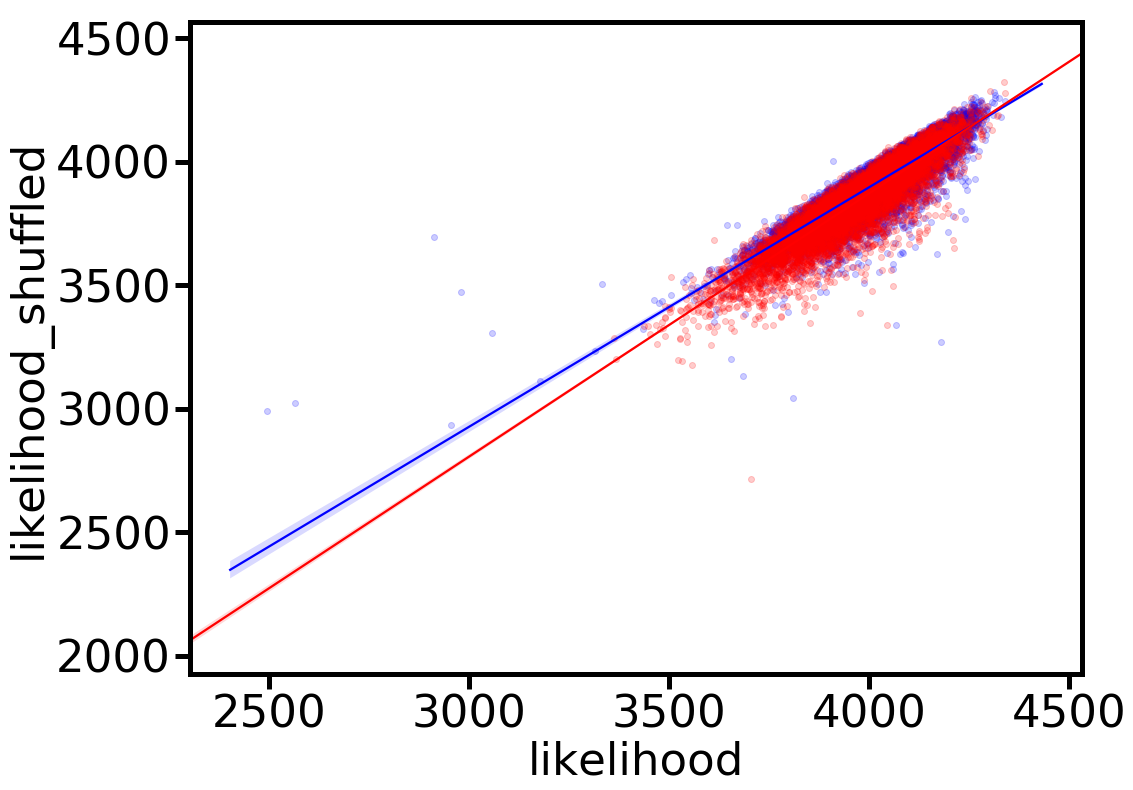

In [31]:
import seaborn as sns
fig,ax=plt.subplots(1,1)
sns.regplot('likelihood', 'likelihood_shuffled',ax=ax, label='n>2.5 SDSS', color='blue', data=LTGs_SDSS, scatter_kws={'alpha':0.2})#, reg=True)
sns.regplot('likelihood', 'likelihood_shuffled',ax=ax, label='n>2.5 SDSS', color='red', data=ETGs_SDSS, scatter_kws={'alpha':0.2})#, reg=True)


In [20]:
SDSS.scatter

In [21]:
len(prova)

5107

In [4]:
d = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/df_cleaned_goodBlobs_SerOnly.dat', sep=' ')

In [5]:
dd= pd.read_csv('/scratch/lzanisi/pixel-cnn/data/cleaned_df_bis_0.02_0.08_blobsLike.dat', sep=' ')

In [15]:
path = '/scratch/lzanisi/pixel-cnn/'
d = pd.read_csv(path+'data/cleaned_df_bis_0.02_0.08_blobsLike.dat', sep=' ')
dd = pd.read_csv(path+'data/df_cleaned_goodBlobs_SerOnly.dat', sep=' ' )

In [29]:
SDSS_orig = pd.read_csv('/scratch/lzanisi/pixel-cnn/outputs/test_double_model/SDSS_df_likelihood_asinh_SDSS_blobsLike_1Msteps_test.csv')
blobs_orig = pd.read_csv('/scratch/lzanisi/pixel-cnn/outputs/test_double_model/blobs_df_likelihood_asinh_SDSS_blobsLike_1Msteps_test.csv')


In [26]:
SDSS_orig.index

RangeIndex(start=0, stop=21237, step=1)

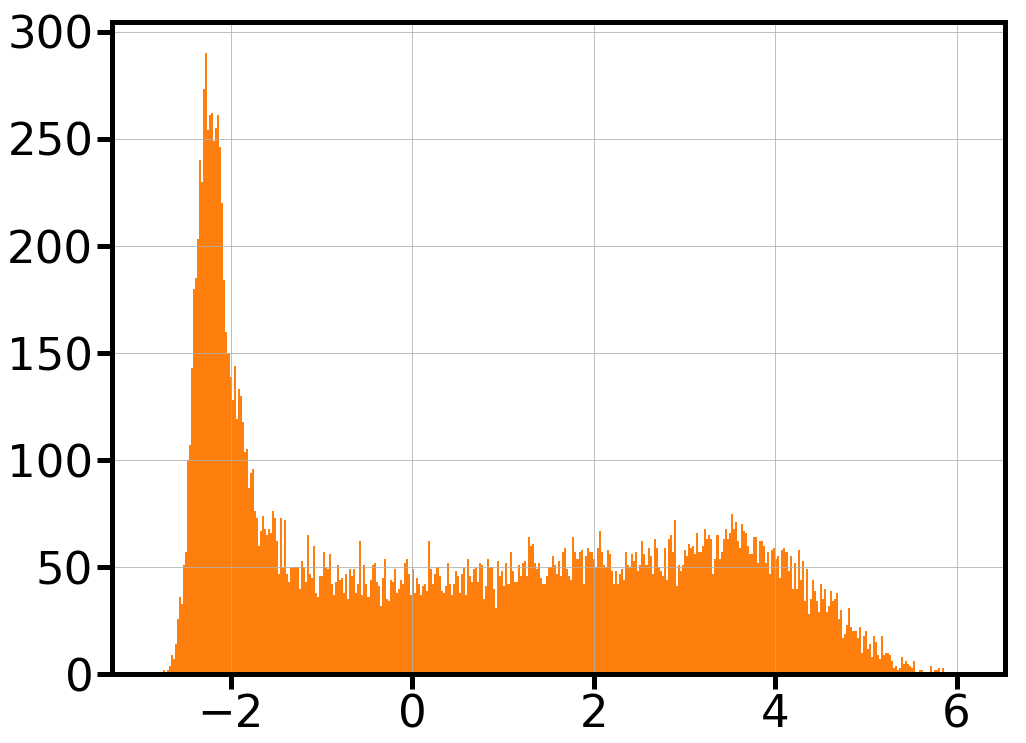

In [30]:
SDSS_orig.TType.hist(bins=400)
blobs_orig.TType.hist(bins=400)

# Generate images for ICLR paper

In [3]:
from astropy.io import fits#


In [4]:
import matplotlib.colors as colors
from astropy.visualization import ZScaleInterval
scaler = ZScaleInterval()

In [7]:
SDS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_Rot_blobsLike.csv')
TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike.csv')
Illustris = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/Illustris_Rot_blobsLike.csv')
blob = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/blobs_Rot_blobsLike.csv')
sk = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/sky_Rot_blobsLike.csv')

In [8]:
L_LTG = SDS.query('objid==588023046406144054').likelihood.values

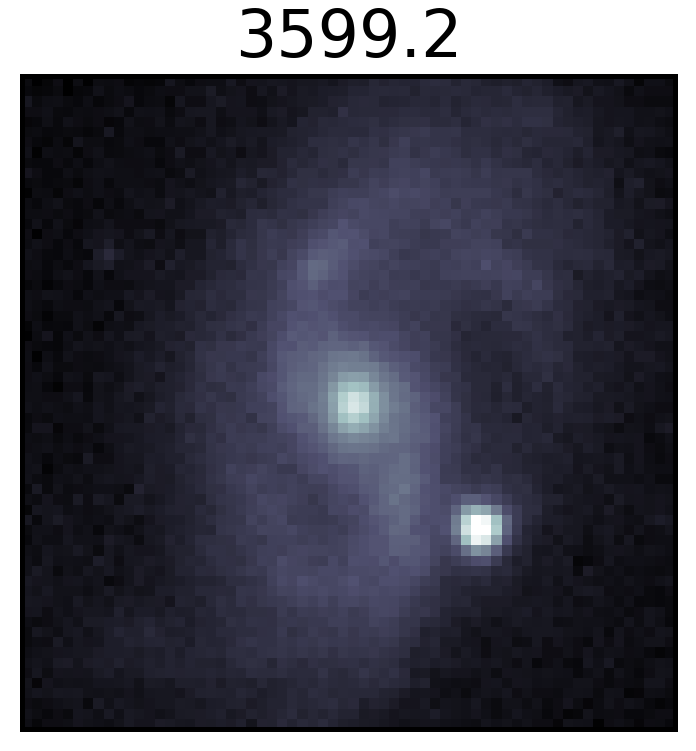

In [221]:
f = fits.getdata('../SDSS_cutouts/0.02_0.08_Mstar_gt10_raw/588023046406144054_r.fits')-1000
plt.imshow(np.arcsinh(f[96:160,96:160]/1000), cmap='bone', norm=colors.LogNorm(vmax=1.2))
plt.title(np.round(L_LTG[0],1), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # l
plt.savefig('/scratch/lzanisi/forPaper/LTG_example.pdf')

In [153]:
L_ETG = SDS.query('objid==587746214282068295').likelihood.values

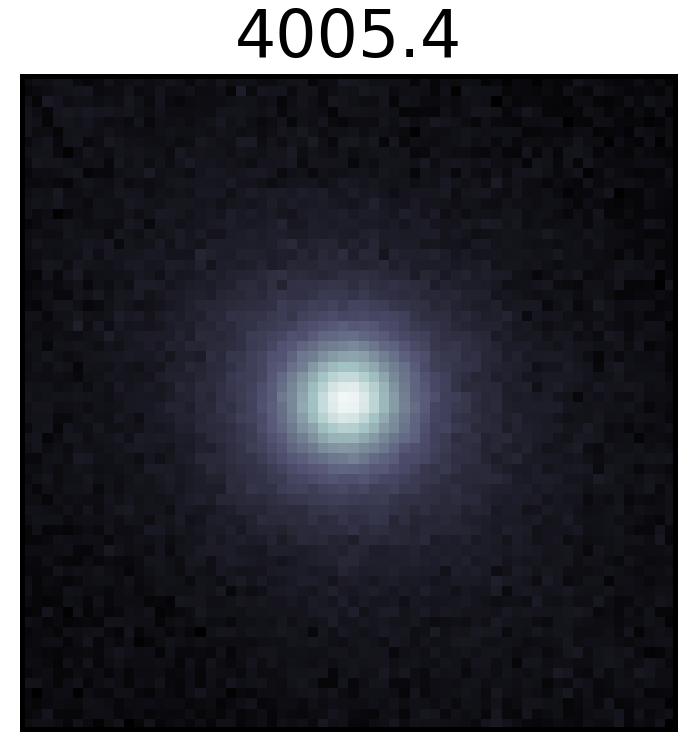

In [222]:
f1 = fits.getdata('../SDSS_cutouts/0.02_0.08_Mstar_gt10_raw/587746214282068295_r.fits')-1000
plt.imshow(np.arcsinh(f1[96:160,96:160]/1000), cmap='bone', norm=colors.LogNorm(vmax=1.35))
plt.title(np.round(L_ETG[0],2), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
plt.savefig('/scratch/lzanisi/forPaper/ETG_example.pdf')


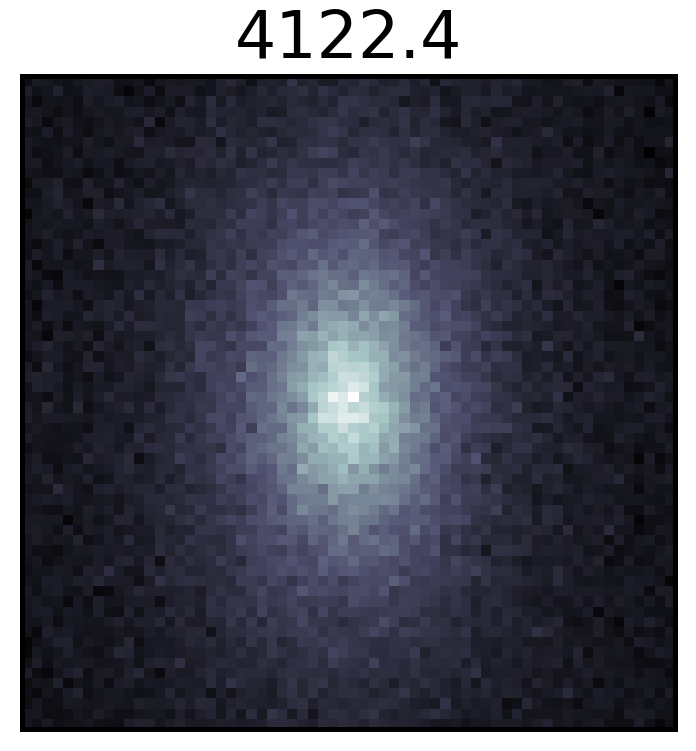

In [223]:
f = fits.getdata('../SDSS_cutouts/0.02_0.08_Mstar_gt10_raw/588023046406144054_r.fits')-1000
fb = fits.getdata('../sersic_blobs/NewBlobs_SerOnly_skysub_FullReal_Uncalibrated/588023046406144054_r.fits')



L_blobs = blob.query('objid==588023046406144054').likelihood.values

plt.imshow(np.arcsinh(fb[32:96,32:96]/1000), cmap='bone')#, norm=colors.LogNorm(vmax=0.23))
plt.title(np.round(L_blobs[0],2), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
plt.savefig('/scratch/lzanisi/forPaper/blob_ofexampleLTG.pdf')


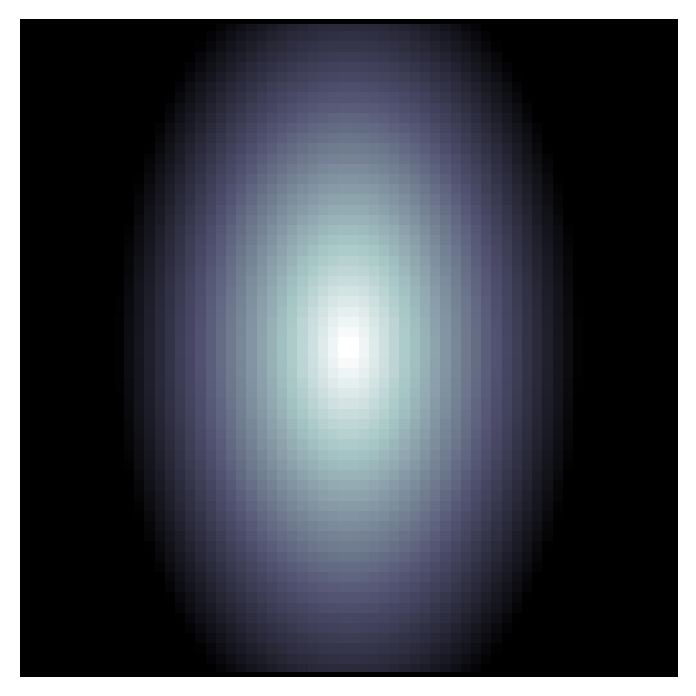

In [220]:
f = fits.getdata('../SDSS_cutouts/0.02_0.08_Mstar_gt10_raw/588023046406144054_r.fits')-1000
fb = fits.getdata('../sersic_blobs/forConnor_SerOnly/588023046406144054_r.fits')



L_blobs = blob.query('objid==588023046406144054').likelihood.values

plt.imshow(fb[32:96,32:96], cmap='bone_r', vmax=23)#, norm=colors.LogNorm(vmax=0.23))
#plt.colorbar()
#plt.title(np.round(L_blobs[0],2), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
plt.savefig('/scratch/lzanisi/forPaper/blob_ofexampleLTG_norealism.pdf')


In [135]:
with open('/scratch/lzanisi/pixel-cnn/TNG_cutouts/0.045_skysub.pkl','rb') as f:
    TNG_obj = pkl.load(f)

In [136]:
data = np.asarray(TNG_obj['data'])

In [138]:
ind = np.where(np.array(TNG_obj['objid'])==455072)[0][0]

In [139]:
img = fits.getdata('/scratch/lzanisi/pixel-cnn/TNG_cutouts/0.045/broadband_455072_FullReal.fits_r_band_FullReal.fits')

In [140]:
L_TNG = TNG.query('objid==455072').likelihood.values[0]

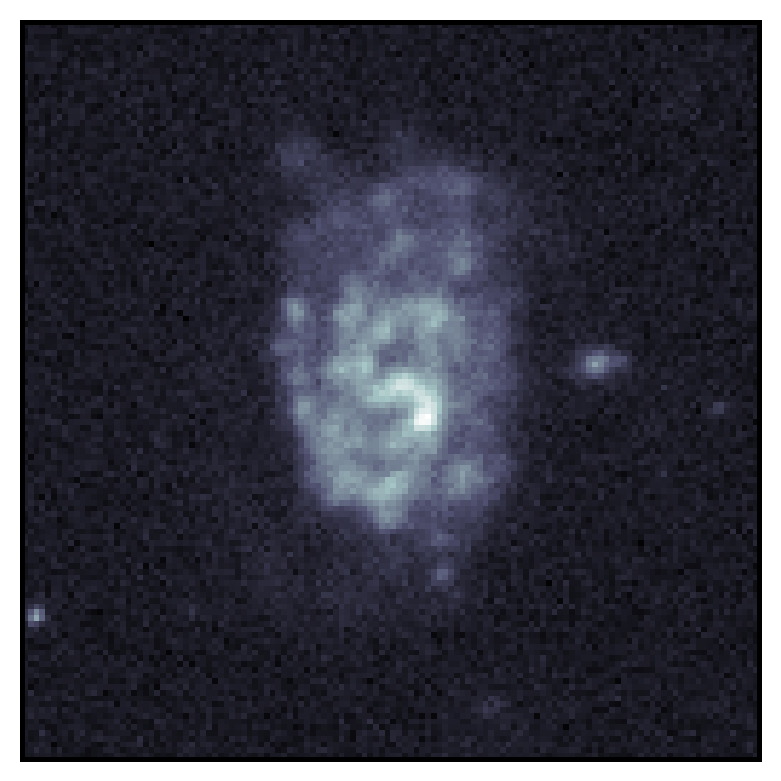

In [143]:
plt.imshow(np.arcsinh(img/1000), cmap='bone', norm=colors.LogNorm())
#plt.title(np.round(L_TNG,1), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
plt.tight_layout()
plt.savefig('/scratch/lzanisi/forPaper/TNG_example.pdf')




In [96]:
img = fits.getdata('/scratch/lzanisi/pixel-cnn/TNG_cutouts/0.045/broadband_455072_FullReal.fits_r_band_FullReal.fits')
img_lessreal  = fits.getdata('/scratch/mhuertas/TNG_SDSS_lessrealism/r_band_noise_PSF/broadband_455072.fits_NOISE_PSF.fits')

#img_lessreal = img = fits.getdata('/scratch/lzanisi/pixel-cnn/TNG_cutouts/0.045/broadband_455072_FullReal.fits_r_band_FullReal.fits')

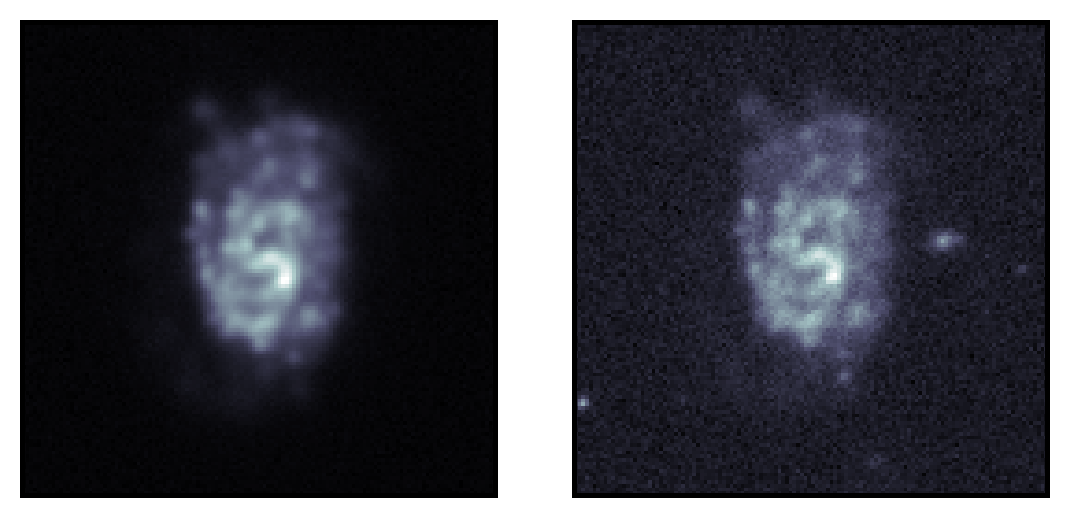

In [145]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(np.arcsinh(img_lessreal/1000), cmap='bone', norm=colors.LogNorm())
#plt.title(np.round(L_TNG,1), fontsize=65)
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
ax2.imshow(np.arcsinh(img/1000), cmap='bone', norm=colors.LogNorm())
#plt.title(np.round(L_TNG,1), fontsize=65)
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
#plt.savefig('/scratch/lzanisi/forPaper/TNG_example_real.png')
plt.tight_layout()
plt.savefig('/scratch/lzanisi/forPaper/TNG_example_real_noreal.png')


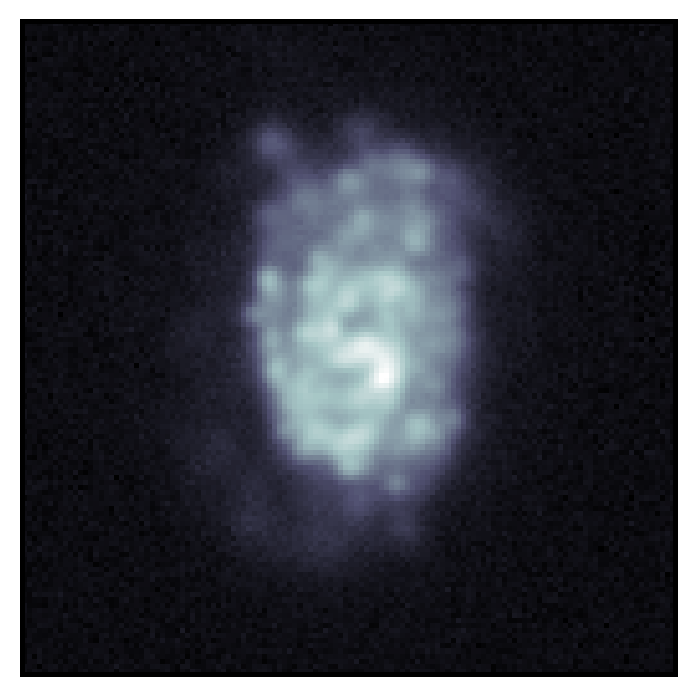

In [134]:
I = img_lessreal-1000
plt.imshow(np.arcsinh(I/1000), cmap='bone', norm=colors.LogNorm(vmin=0.12 ))
#plt.title(np.round(L_TNG,1), fontsize=65)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
plt.savefig('/scratch/lzanisi/forPaper/TNG_example_lessreal.png')


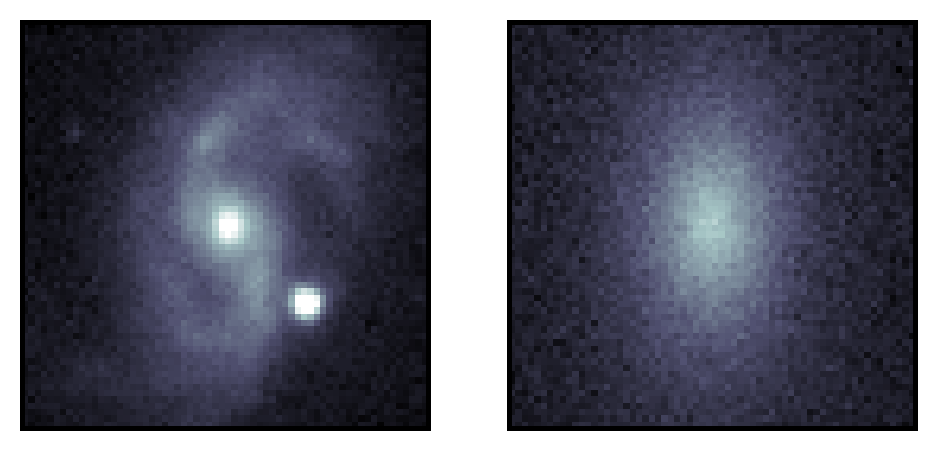

In [147]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(np.arcsinh(f[96:160,96:160]/1000), cmap='bone', norm=colors.LogNorm(vmax=0.7))
ax2.imshow(np.arcsinh(fb[32:96,32:96]/1000), cmap='bone', norm=colors.LogNorm(vmax=0.3))
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off


In [189]:
import pickle as pkl
import numpy as np

In [29]:
with open('../outputs/TNG/data_asinh_SDSS_blobsLike_1Msteps_test.pkl','rb') as f:
    obj = pkl.load(f)

with open('../outputs/TNG/lmap_asinh_SDSS_blobsLike_1Msteps_test.pkl','rb') as f:
    lmap_SDSS = pkl.load(f)


with open('../outputs/TNG/lmap_asinh_NewSersicBlobs_SerOnly_1Msteps_test.pkl','rb') as f:
    lmap_blobs = pkl.load(f)

In [30]:
# use for the TNG image
ind_data = obj['data_rot'][np.where(obj['objid']==498550)[0][0]]
ind_lmap_SDSS = lmap_SDSS['likelihoodmap'][np.where(lmap_SDSS['objid']==498550)[0][0]]
ind_lmap_blobs = lmap_blobs['likelihoodmap'][np.where(lmap_blobs['objid']==498550)[0][0]]

In [23]:
# use for the SDSS image - change two cells above accordingly
ind_data = obj['data_rot'][np.where(obj['objid']==588010358002483370)[0][0]]
ind_lmap_SDSS = lmap_SDSS['likelihoodmap'][np.where(lmap_SDSS['objid']==588010358002483370)[0][0]]
ind_lmap_blobs = lmap_blobs['likelihoodmap'][np.where(lmap_blobs['objid']==588010358002483370)[0][0]]

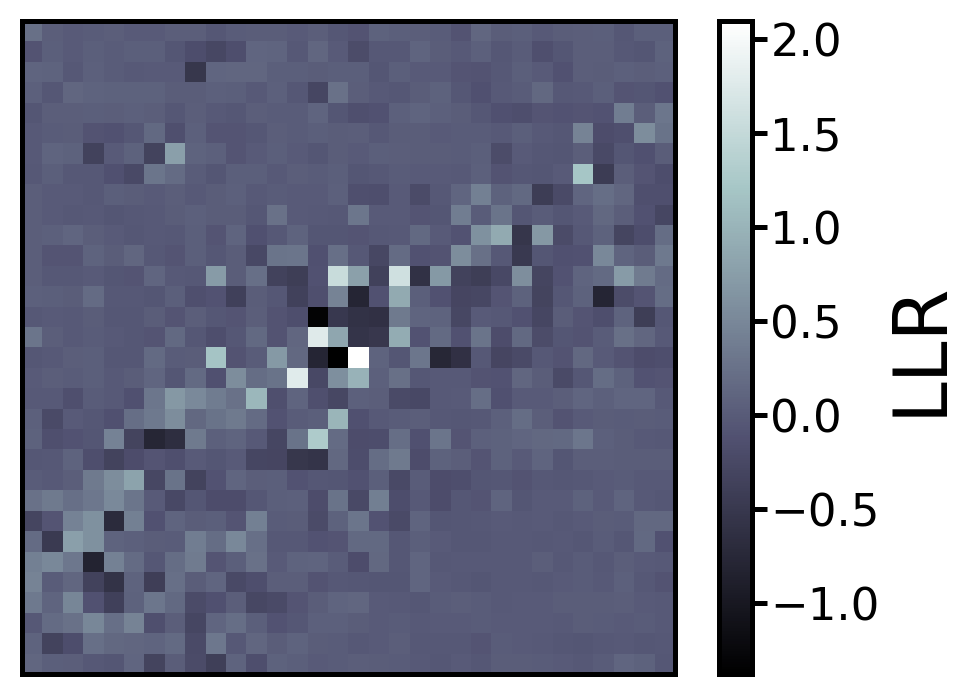

In [32]:
fig,ax1 = plt.subplots(1,1)#, figsize=(20,12))
llr= ind_lmap_SDSS-ind_lmap_blobs

im= ax1.imshow(llr,cmap='bone')#, vmin=-3, vmax=5)#  norm=colors.SymLogNorm(linthresh=0.05))

cbar = fig.colorbar(im, ax=ax1)
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
cbar.set_label('LLR', fontsize=75)
#plt.savefig('/scratch/lzanisi/forPaper/exampleSDSS_forLLR_llrmap.pdf')

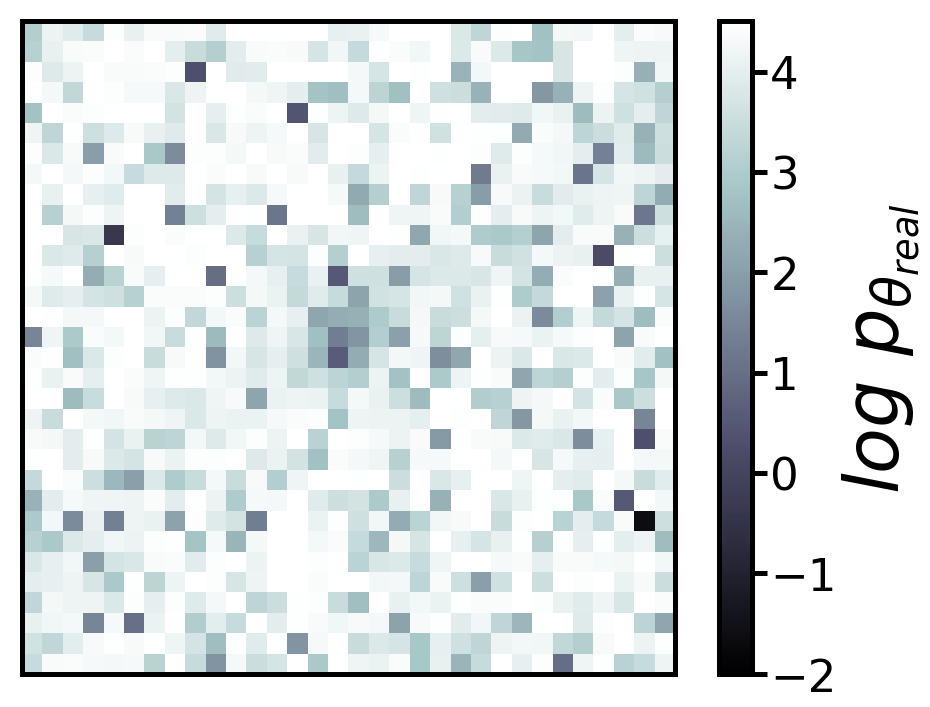

In [31]:
fig,ax1 = plt.subplots(1,1)#, figsize=(20,12))
llr= ind_lmap_SDSS-ind_lmap_blobs

im=ax1.imshow(ind_lmap_SDSS,cmap='bone', vmax=4.5, vmin=-2)#, vmax=2)#, norm=colors.SymLogNorm(linthresh=0.05))

cbar = fig.colorbar(im, ax=ax1)
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
cbar.set_label(r'$log \ p_{\theta_{real}}$', fontsize=75)
plt.savefig('/scratch/lzanisi/forPaper/exampleTNG_forLLR_lmapSDSS.png')

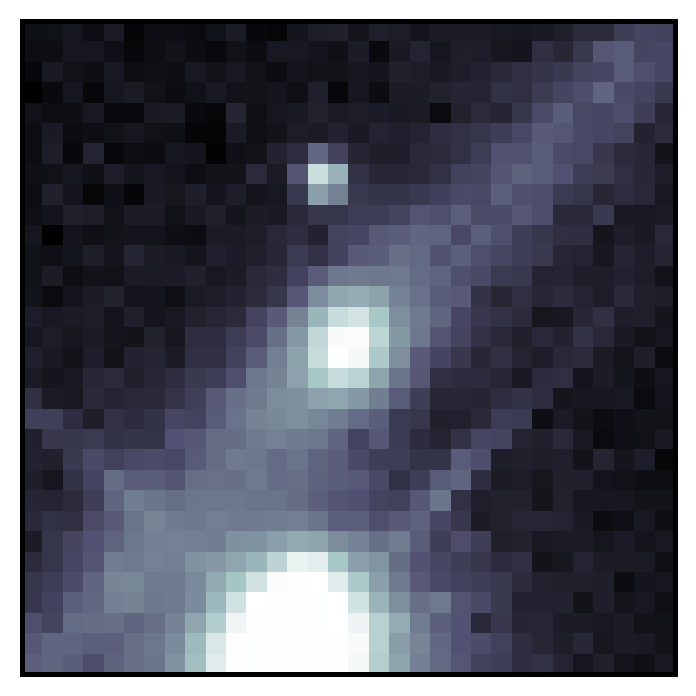

In [203]:
fig,ax1 = plt.subplots(1,1)#, figsize=(20,12))
llr= ind_lmap_SDSS-ind_lmap_blobs

im=ax1.imshow(ind_data,cmap='bone', norm=colors.SymLogNorm(linthresh=0.05))

#fig.colorbar(im, ax=ax1)
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off

plt.savefig('/scratch/lzanisi/forPaper/exampleTNG_forLLR_galaxy.pdf')

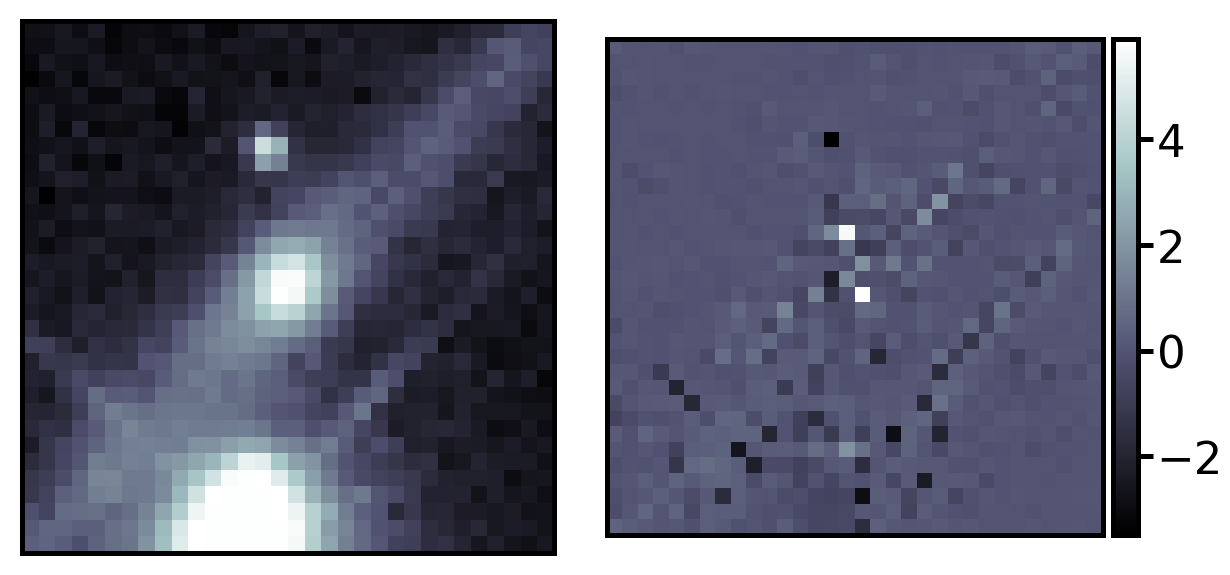

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,12))
llr= ind_lmap_SDSS-ind_lmap_blobs
ax1.imshow(ind_data,cmap='bone', norm=colors.SymLogNorm(linthresh=0.05))
im = ax2.imshow(llr,cmap='bone')#, norm=colors.SymLogNorm(linthresh=0.8))
divider = make_axes_locatable(ax2)
fig.subplots_adjust(wspace=0.1)

cax = divider.append_axes('right', size='5%', pad=0.15)
#cax= fig.add_axes([0.85,0.05,0.05,0.45])
fig.colorbar(im, cax=cax)
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # labels along the bottom edge are off



# cutouts of TNG, SDSS and TNG50 in same mass range

In [209]:
df_50 = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG50_Rot_blobsLike.csv')
with open('/scratch/lzanisi/pixel-cnn/TNG50_cutouts/0.045_skysub.pkl','rb') as f:
    o_50 = pkl.load(f)

data50 = np.array(o_50['data'])

In [210]:
df_TNG = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/TNG_Rot_blobsLike.csv')
with open('/scratch/lzanisi/pixel-cnn/TNG_cutouts/0.045_skysub.pkl','rb') as f:
    o_TNG = pkl.load(f)

dataTNG = np.array(o_TNG['data'])

In [251]:
df_SDSS = pd.read_csv('/scratch/lzanisi/pixel-cnn/data/DataFrames_LLR/SDSS_newsky_Rot_blobsLike.csv')
with open('/scratch/lzanisi/pixel-cnn/SDSS_cutouts/0.02_0.08_Mstar_gt10_asinh_test_blobsLike_newskysub.pkl','rb') as f:
    o_SDSS = pkl.load(f)

dataSDSS = np.array(o_SDSS['data'])

In [246]:
massup = 11.5
masslow = 11

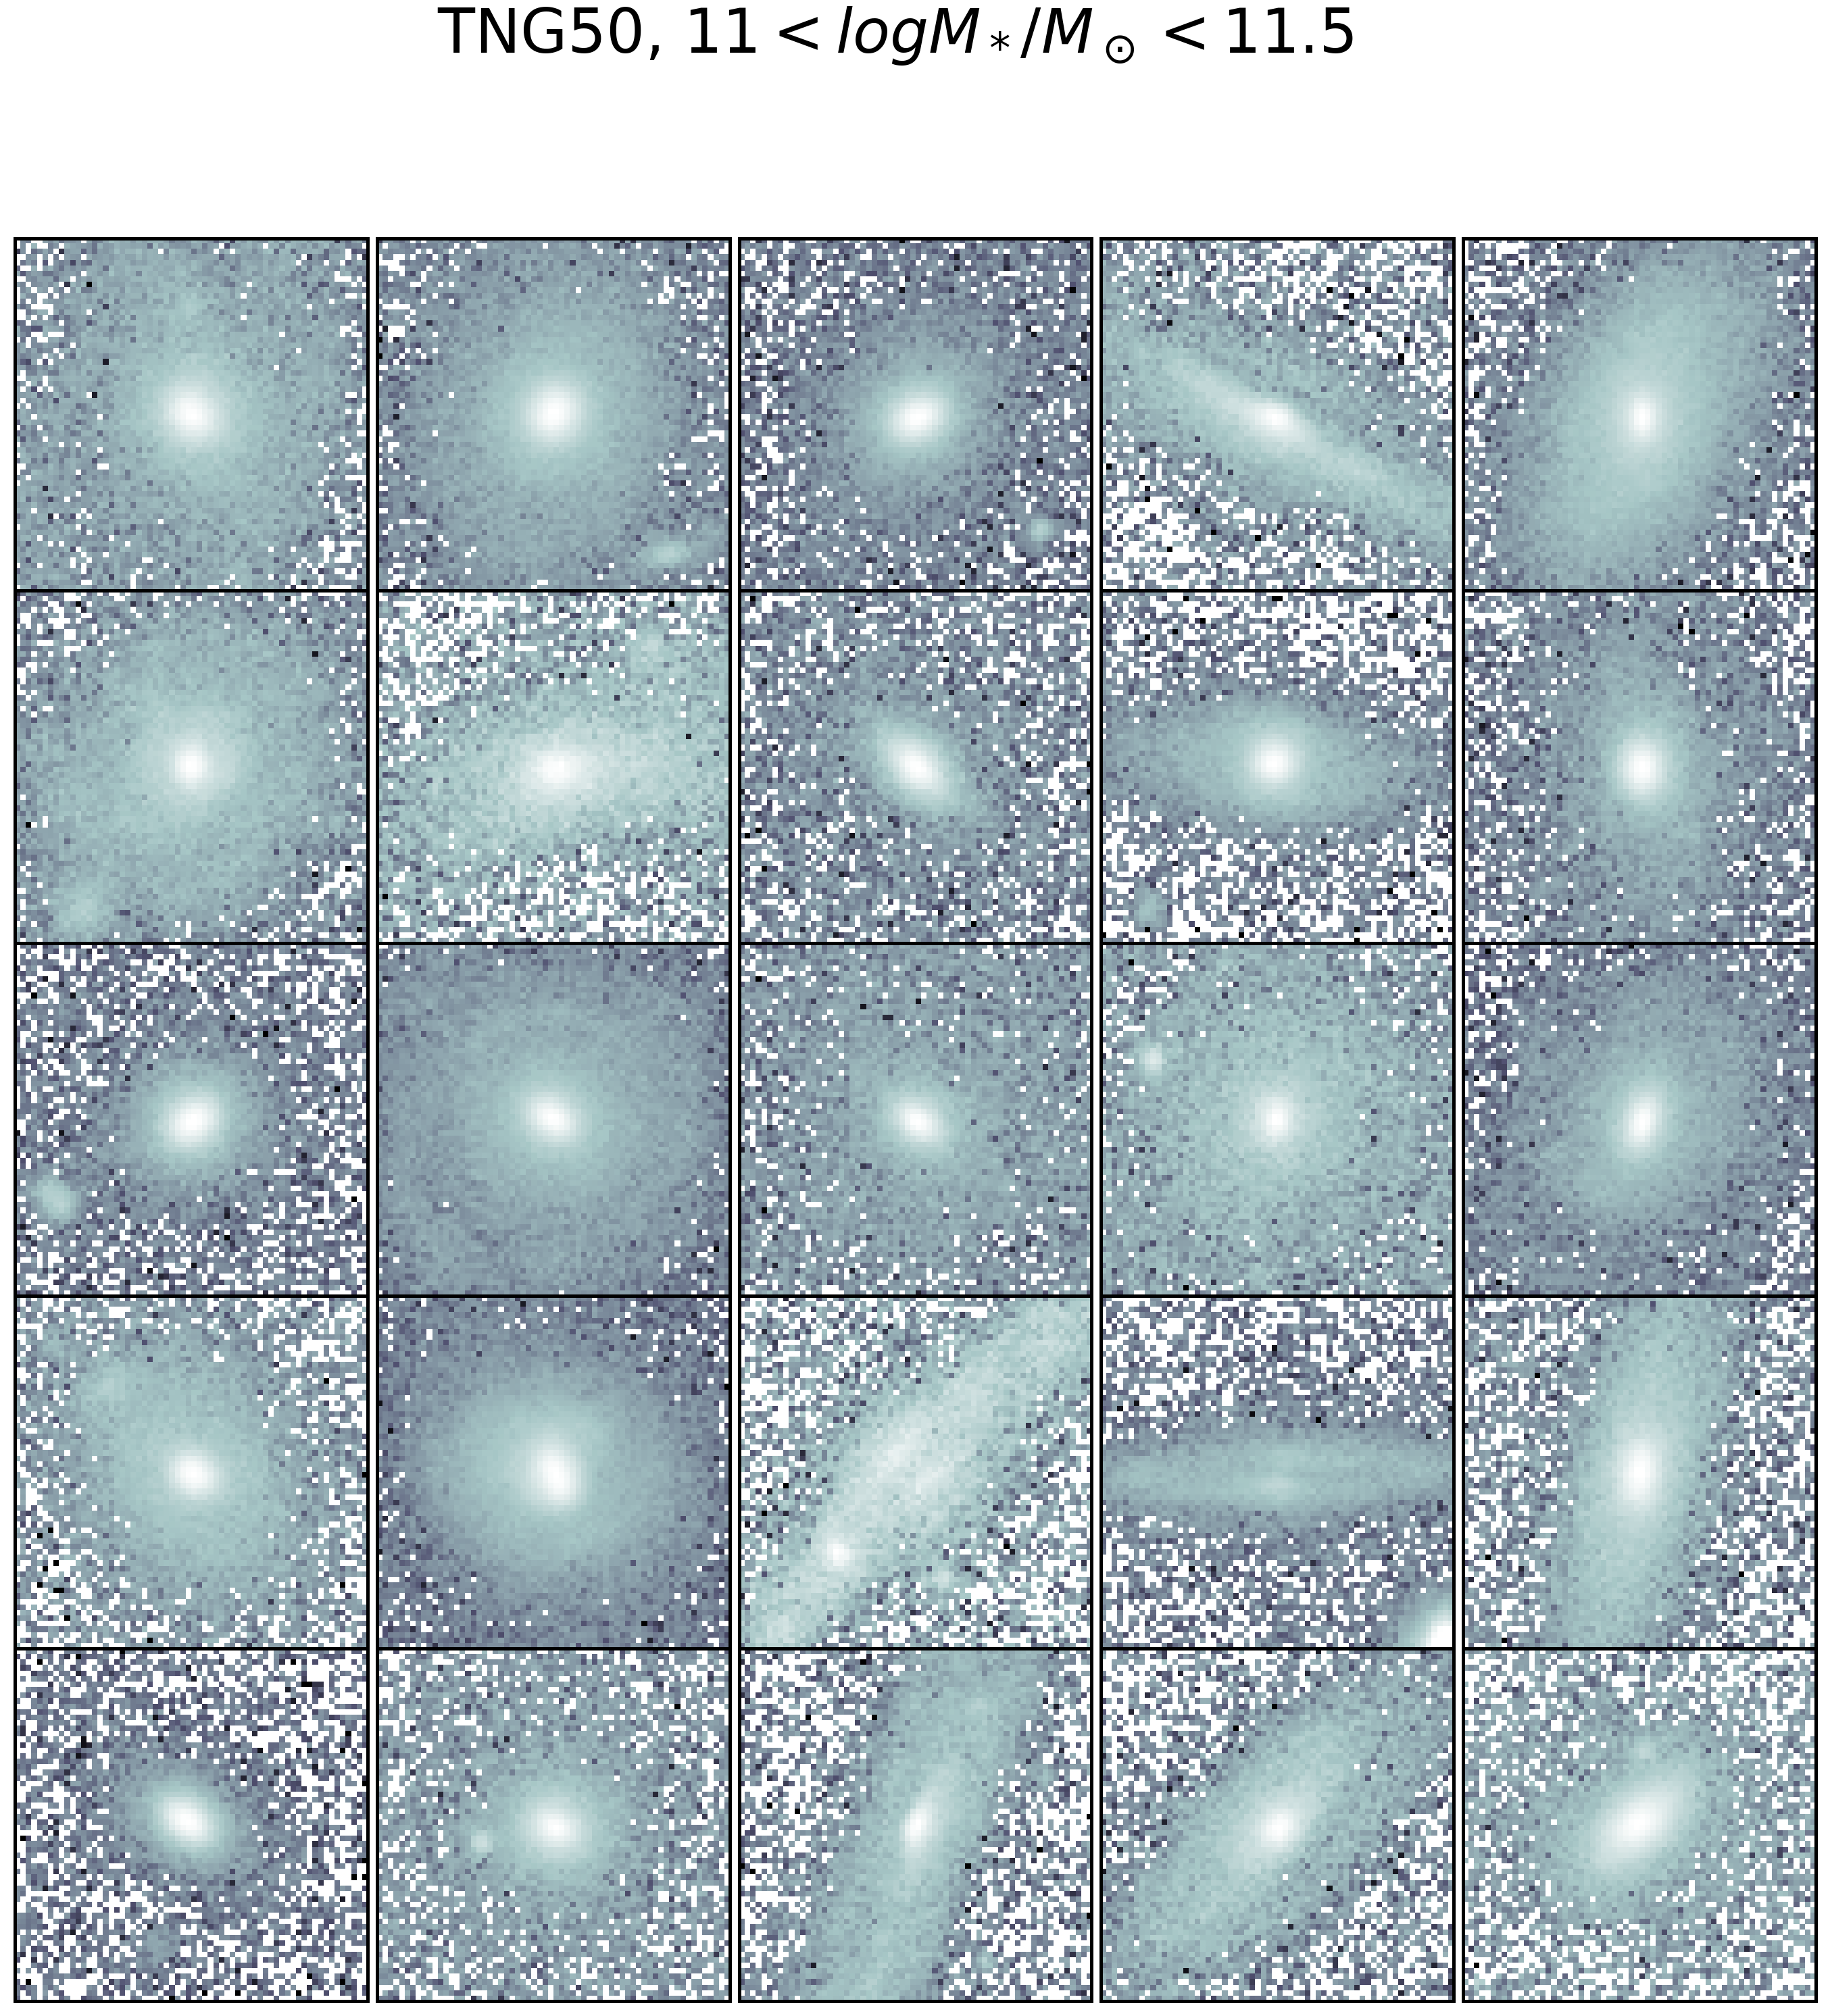

In [247]:

size = 25
df_50_ = df_50.query('StellarMassTotal>{} & StellarMassTotal<{}'.format(masslow,massup))
index = df_50_.index
ind = np.random.choice( index, replace=False, size=size)
d = data50[ind,:,:]

fig, ax = plt.subplots(5,5, figsize=(48,48))

for im,t in zip(d,ax.ravel()):
    t.imshow(im[32:96,32:96], cmap='bone', norm=colors.LogNorm())
    t.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # 
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(' TNG50, ${}<logM_*/M_\odot<{}$'.format(masslow, massup), fontsize=90)
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/MassCutsExploration/TNG50_{}_{}.png'.format(masslow,massup))






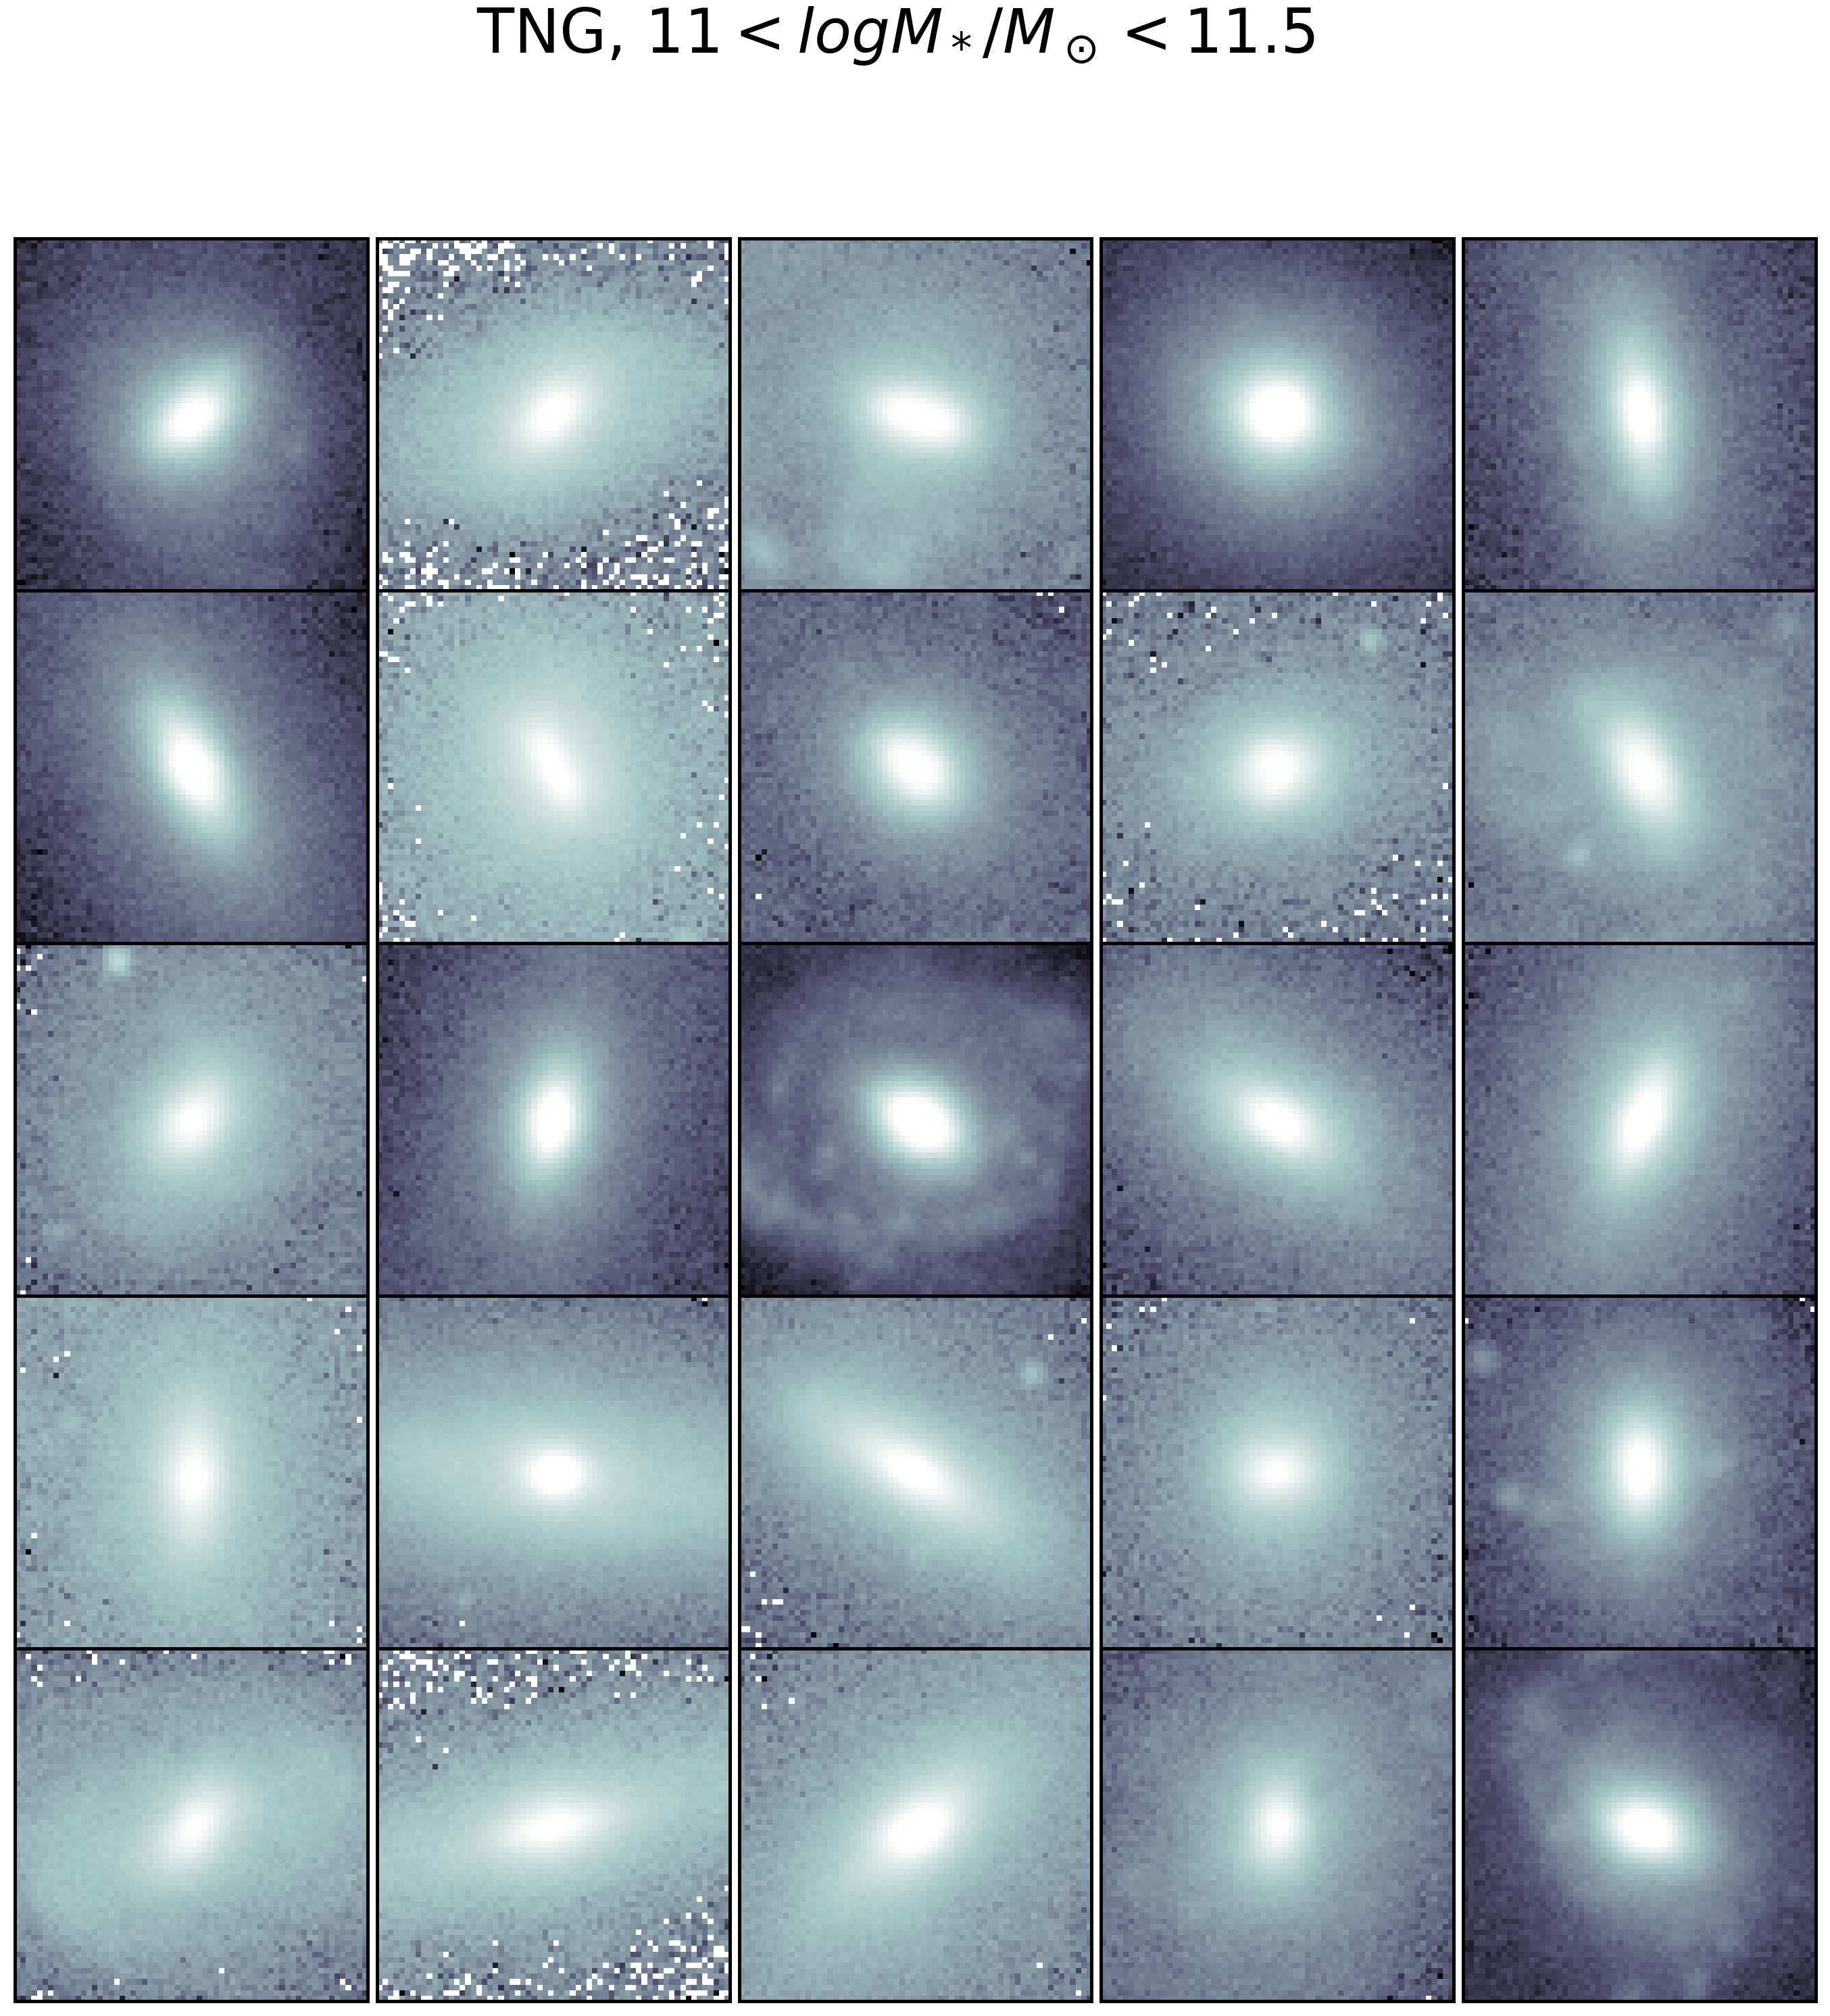

In [248]:

size = 25
df_TNG_ = df_TNG.query('LogMass30>{} & LogMass30<{}'.format(masslow,massup))
index = df_TNG_.index
ind = np.random.choice( index, replace=False, size=size)
d = dataTNG[ind,:,:]

fig, ax = plt.subplots(5,5, figsize=(48,48))

for im,t in zip(d,ax.ravel()):
    t.imshow(im[32:96,32:96], cmap='bone', norm=colors.LogNorm())
    t.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # 
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(' TNG, ${}<logM_*/M_\odot<{}$'.format(masslow, massup), fontsize=90)
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/MassCutsExploration/TNG_{}_{}.png'.format(masslow,massup))

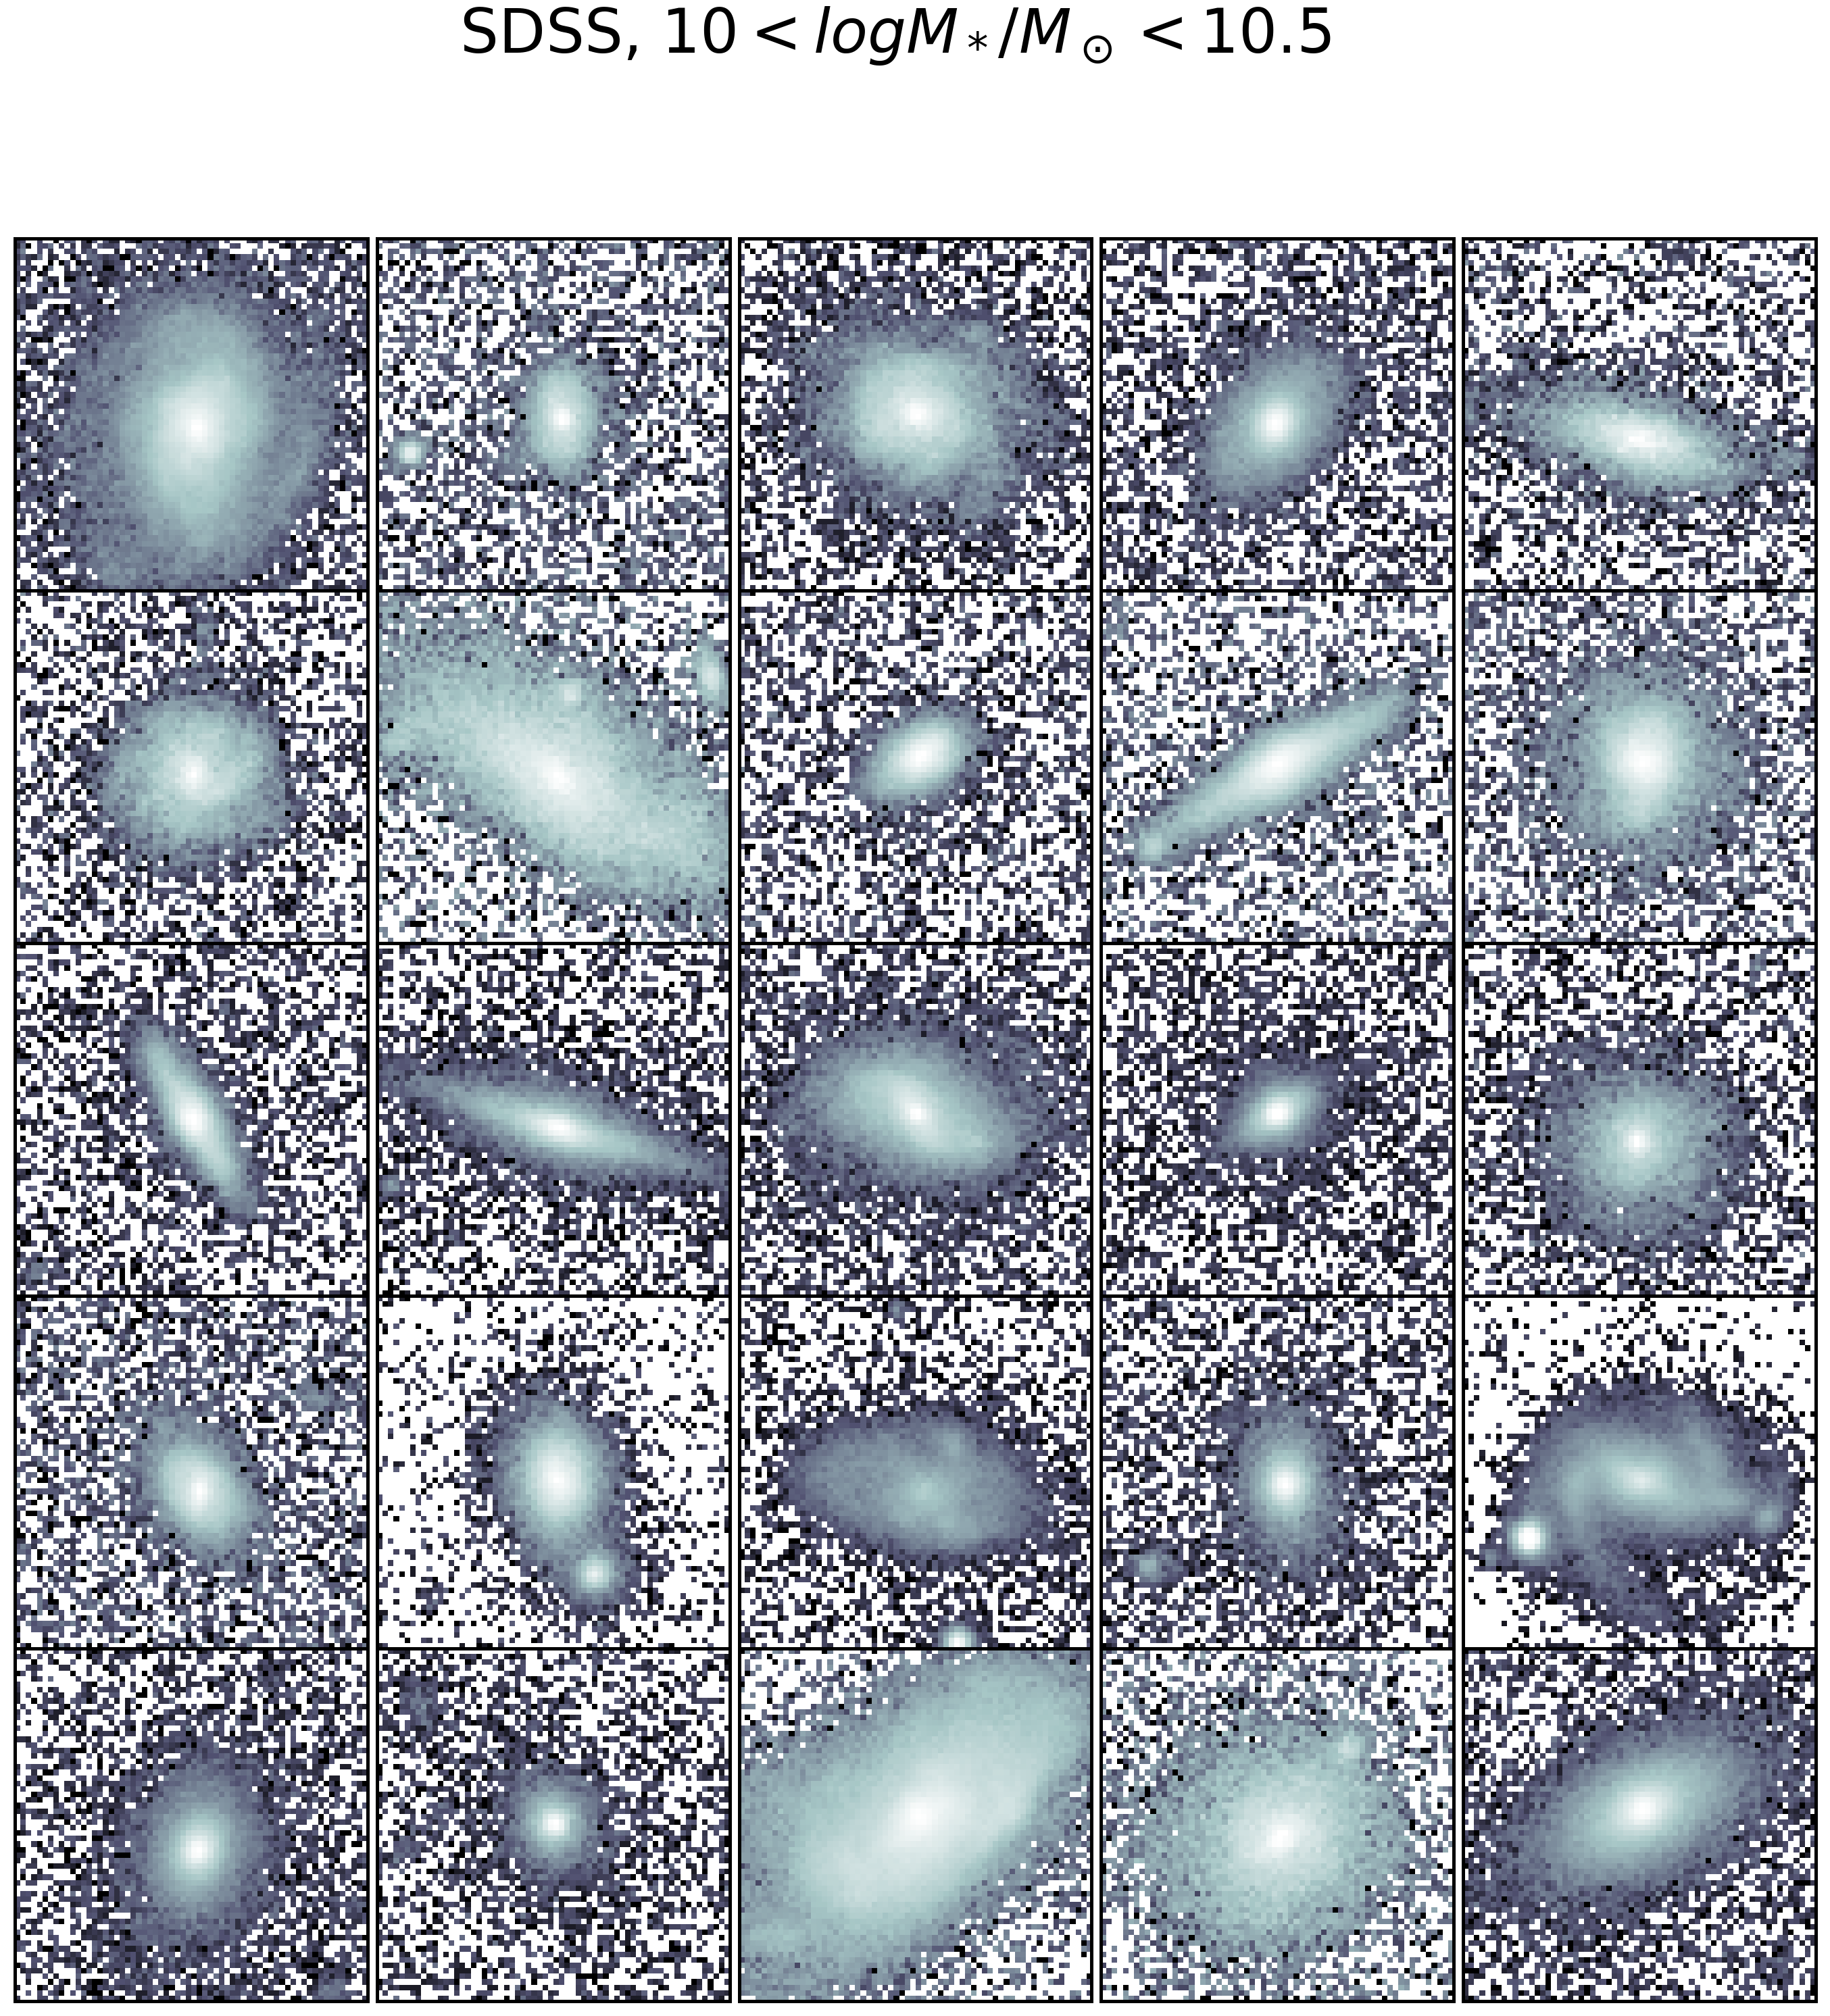

In [253]:
masslow=10
massup = masslow+0.5

size = 25
df_SDSS_ = df_SDSS.query('MsMendSerExp>{} & MsMendSerExp<{}'.format(masslow,massup))
index = df_SDSS_.index
ind = np.random.choice( index, replace=False, size=size)
d = dataSDSS[ind,:,:]

fig, ax = plt.subplots(5,5, figsize=(48,48))

for im,t in zip(d,ax.ravel()):
    t.imshow(im[32:96,32:96], cmap='bone', norm=colors.LogNorm())
    t.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    left=False,
    labelleft=False) # 
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(' SDSS, ${}<logM_*/M_\odot<{}$'.format(masslow, massup), fontsize=90)
plt.savefig('/scratch/lzanisi/pixel-cnn/analysis/results/MassCutsExploration/SDSS_newskysub_{}_{}.png'.format(masslow,massup))


In [259]:
from glob import glob
names = glob('/scratch/lzanisi/pixel-cnn/sersic_blobs/NewBlobs_SerOnly_skysub_FullReal/NewBlobs/*')

In [256]:
fits.getheader('/scratch/lzanisi/pixel-cnn/sersic_blobs/NewBlobs_SerOnly_skysub_FullReal/NewBlobs/587733409917894966_r_FullReal.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  128                                                  
NAXIS2  =                  128                                                  
EXTEND  =                    T                                                  
REDSHIFT=                 0.05 / Redshift                                       
CDELT1  =    576.9930000000001                                                  
PSF_FWHM=                  0.1                                                  
BUNIT   = 'AB nanomaggies'                                                      
RUN     =                 5116 / SDSS image RUN                                 
RERUN   =                   40 / SDSS image RERUN                               
CAMCOL  =                   